In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import numpy as np
import pandas as pd
from pyproj import Transformer, CRS
from shapely.geometry import Point
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from pandas import DataFrame, Series
from matplotlib.pyplot import Axes
import rasterio
from rasterio.enums import Resampling
from osgeo import gdal

## Data wrangling

- field data will be given the prefix `field`
- pre-selected site data will be given the prefix `site`
- merge `field` and `site` data
- remove unwanted columns from the field data
- rename columns to meaningful names
- created smaller database with just average results

set up lookup tables and helper functions

In [2]:
# superset of column names
all_cols = {
    'globalid': ['id', 'Unique Site ID'],
    'Site': ['site', 'Site No'],
    'plot': ['plot', 'Plot No'], 
    'Date': ['date', 'Date'], 
    'Name': ['name', 'Assessor Name'], 
    'Fuel': ['veg_type', 'Vegetation Class'],
    'FireHistor': ['fire_hist', 'Time since Fire (y)'], 
    'latitude': ['lat', 'Latitude (°)'], 
    'longitude': ['lon', 'Longitude (°)'],
    'horaccmete': ['loc_accuracy', 'Location accuracy (m)'],
    'FuelDepth1': ['litter_d_1', 'Litter Depth: Sample 1 (mm)'],
    'Cover1': ['litter_state_1', 'Litter State: Sample 1 (presence/absence)'], 
    'NearSurfac': ['ns_h_1', 'Near surface fuel height: Sample 1 (m)'],
    'NearSurf_1': ['ns_state_1', 'Near surface fuel state: Sample 1 (absent/alive/dead)'],
    'Elevated1': ['elev_h_1', 'Elevated fuel height: Sample 1 (m)'],
    'ElevatedCo': ['elev_state_1', 'Elevated fuel state: Sample 1 (absent/alive/dead)'],
    'CanopyHeig': ['canopy_h_1', 'Canopy height: Sample 1 (m)'],
    'CanopyCove': ['canopy_cov_1', 'Canopy cover: Sample 1 (%)'],
    'FuelDepth2': ['litter_d_2', 'Litter Depth: Sample 2 (mm)'], 
    'Cover2': ['litter_state_2', 'Litter State: Sample 2 (presence/absence)'],
    'NearSurf_2': ['ns_h_2', 'Near surface fuel height: Sample 2 (m)'], 
    'NearSurf_3': ['ns_state_2', 'Near surface fuel state: Sample 2 (absent/alive/dead)'],
    'Elevated2': ['elev_h_2', 'Elevated fuel height: Sample 2 (m)'],
    'Elevated_1': ['elev_state_2', 'Elevated fuel state: Sample 2 (absent/alive/dead)'],
    'FuelDepth3': ['litter_d_3', 'Litter Depth: Sample 3 (mm)'],
    'Cover3': ['litter_state_3', 'Litter State: Sample 3 (presence/absence)'],
    'NearSurf_4': ['ns_h_3', 'Near surface fuel height: Sample 3 (m)'],
    'NearSurf_5': ['ns_state_3', 'Near surface fuel state: Sample 3 (absent/alive/dead)'],
    'Elevated3': ['elev_h_3', 'Elevated fuel height: Sample 3 (m)'],
    'Elevated_2': ['elev_state_3', 'Elevated fuel state: Sample 3 (absent/alive/dead)'],
    'CanopyHe_1': ['canopy_h_3', 'Canopy height: Sample 3 (m)'],
    'CanopyCo_1': ['canopy_cov_3', 'Canopy cover: Sample 3 (%)'],
    'FuelDepth4': ['litter_d_4', 'Litter Depth: Sample 4 (mm)'],
    'Cover4': ['litter_state_4', 'Litter State: Sample 4 (presence/absence)'],
    'NearSurf_6': ['ns_h_4', 'Near surface fuel height: Sample 4 (m)'],
    'NearSurf_7': ['ns_state_4', 'Near surface fuel state: Sample 4 (absent/alive/dead)'],
    'Elevated4': ['elev_h_4', 'Elevated fuel height: Sample 4 (m)'],
    'Elevated_3': ['elev_state_4', 'Elevated fuel state: Sample 4 (absent/alive/dead)'],
    'FuelDepth5': ['litter_d_5', 'Litter Depth: Sample 5 (mm)'],
    'Cover5': ['litter_state_5', 'Litter State: Sample 5 (presence/absence)'],
    'NearSurf_8': ['ns_h_5', 'Near surface fuel height: Sample 5 (m)'],
    'NearSurf_9': ['ns_state_5', 'Near surface fuel state: Sample 5 (absent/alive/dead)'],
    'Elevated5': ['elev_h_5', 'Elevated fuel height: Sample 5 (m)'],
    'Elevated_4': ['elev_state_5', 'Elevated fuel state: Sample 5 (absent/alive/dead)'],
    'CanopyHe_2': ['canopy_h_5', 'Canopy height: Sample 5 (m)'],
    'CanopyCo_2': ['canopy_cov_5', 'Canopy cover: Sample 5 (%)'],
    'FuelDepth6': ['litter_d_6', 'Litter Depth: Sample 6 (mm)'],
    'Cover6': ['litter_state_6', 'Litter State: Sample 6 (presence/absence)'],
    'NearSur_10': ['ns_h_6', 'Near surface fuel height: Sample 6 (m)'],
    'NearSur_11': ['ns_state_6', 'Near surface fuel state: Sample 6 (absent/alive/dead)'],
    'Elevated6': ['elev_h_6', 'Elevated fuel height: Sample 6 (m)'],
    'Elevated_5':['elev_state_6', 'Elevated fuel state: Sample 6 (absent/alive/dead)'],
    'FuelDepth7': ['litter_d_7', 'Litter Depth: Sample 7 (mm)'],
    'Cover7': ['litter_state_7', 'Litter State: Sample 7 (presence/absence)'],
    'NearSur_12': ['ns_h_7', 'Near surface fuel height: Sample 7 (m)'],
    'NearSur_13': ['ns_state_7', 'Near surface fuel state: Sample 7 (absent/alive/dead)'],
    'Elevated7': ['elev_h_7', 'Elevated fuel height: Sample 7 (m)'],
    'Elevated_6': ['elev_state_7', 'Elevated fuel state: Sample 7 (absent/alive/dead)'],
    'CanopyHe_3': ['canopy_h_7', 'Canopy height: Sample 7 (m)'],
    'CanopyCo_3': ['canopy_cov_7', 'Canopy cover: Sample 7 (%)'],
    'FuelDepth8': ['litter_d_8', 'Litter Depth: Sample 8 (mm)'], 
    'Cover8': ['litter_state_8', 'Litter State: Sample 8 (presence/absence)'],
    'NearSur_14': ['ns_h_8', 'Near surface fuel height: Sample 8 (m)'],
    'NearSur_15': ['ns_state_8', 'Near surface fuel state: Sample 8 (absent/alive/dead)'],
    'Elevated8': ['elev_h_8', 'Elevated fuel height: Sample 8 (m)'],
    'Elevated_7': ['elev_state_8', 'Elevated fuel state: Sample 8 (absent/alive/dead)'],
    'FuelDepth9': ['litter_d_9', 'Litter Depth: Sample 9 (mm)'],
    'Cover9': ['litter_state_9', 'Litter State: Sample 9 (presence/absence)'],
    'NearSur_16': ['ns_h_9', 'Near surface fuel height: Sample 9 (m)'],
    'NearSur_17': ['ns_state_9', 'Near surface fuel state: Sample 9 (absent/alive/dead)'],
    'Elevated9': ['elev_h_9', 'Elevated fuel height: Sample 9 (m)'],
    'Elevated_8': ['elev_state_9', 'Elevated fuel state: Sample 9 (absent/alive/dead)'],
    'CanopyHe_4': ['canopy_h_9', 'Canopy height: Sample 9 (m)'],
    'CanopyCo_4': ['canopy_cov_9', 'Canopy cover: Sample 9 (%)'],
    'FuelDept_1': ['litter_d_10', 'Litter Depth: Sample 10 (mm)'],
    'Cover10': ['litter_state_10', 'Litter State: Sample 10 (presence/absence)'],
    'NearSur_18': ['ns_h_10', 'Near surface fuel height: Sample 10 (m)'],
    'NearSur_19': ['ns_state_10', 'Near surface fuel state: Sample 10 (absent/alive/dead)'],
    'Elevated10': ['elev_h_10', 'Elevated fuel height: Sample 10 (m)'],
    'Elevated_9': ['elev_state_10', 'Elevated fuel state: Sample 10 (absent/alive/dead)'],
    'AverageFue': ['litter_d_m', 'Mean litter depth (mm)'],
    'AverageSur': ['litter_state_count', 'Litter cover P/A count (/10)'],
    'AveragePer': ['litter_cov', 'Litter cover (%)'],
    'FuelLoad': ['litter_load', 'Litter fuel load (t/ha)'],
    'Fuel_Hazar': ['s_fhr', 'Surface fuel hazard rating'], 
    'averageNSh': ['ns_h_m', 'Mean near surface height (m)'], 
    'averageNSc': ['ns_state_count', 'Near Surface P/A count (/10)'], 
    'averageN_1': ['ns_cov', 'Near surface cover (%)'], 
    'averageNSd': ['ns_dead_count', 'Near surface dead count'], 
    'percentage': ['ns_dead_%', 'Near surface dead as percentage of near surface present'], 
    'nearsur_20': ['_ns_fhr', 'Near surface Fuel Hazard Rating'], # repeat?
    'Near_Surfa': ['ns_fhr', 'Near surface Fuel Hazard Rating'], 
    'nearsur_21': ['ns_load', 'Near surface fuel load (t/ha)'], 
    'combined': ['s&ns_fhr', 'Combined surface and near surface Fuel Hazard Rating'], 
    'averageele': ['elev_h_m', 'Mean elevated height (m)'], 
    'averagee_1': ['elev_state_count', 'Elevated P/A count (/10)'], 
    'averagee_2': ['elev_cov', 'elevated cover (%)'], 
    'averagee_3': ['elev_dead_count', 'Elevated dead count'],
    'elevatedpe': ['elev_dead_%', 'elevated dead as percentage of elevated present'], 
    'elevated_f': ['_elev_fhr', 'Elevated Fuel Hazard Rating'], # repeat?
    'elevated_h': ['elev_fhr', 'Elevated Fuel Hazard Rating'], 
    'elevate_10': ['elev_load', 'Elevated fuel load (t/ha)'], 
    'bark_type': ['bark_type', 'Bark type'], 
    'bark_fuel': ['bark_haz&type', 'Bark hazard rating and type'], 
    'bark_hazar': ['bark_haz', 'Bark hazard rating'], 
    'bark_fuell': ['bark_load', 'Bark fuel load (t/ha)'], 
    'height_ave': ['canopy_h_m', 'Mean canopy height (m)'], 
    'cannopy_av':['canopy_cov_m', 'Mean canopy cover (%)'], 
    'plotgood': ['representative', 'Plot is representative of area (Y/N)'], 
    'comments': ['comments', 'Comments'],
    'geometry': ['geometry', 'Shapefile geometry'],
}

#AFO layer names and descriptions
labels = {
    'afo_cc': 'AFO Crown Cover %',
    'afo_lfd': 'AFO Ladder Fuel Density',
    'afo_ch': 'AFO Canopy Height (m)',
    'afo_cbh': 'AFO Canopy Base Height (m)',
    'afo_litter': 'AFO litter fuel load (t/ha)', 
    'afo_surface': 'AFO surface fuel load (t/ha)', 
    'afo_elevated': 'AFO elevated fuel  load (t/ha)', 
    'afo_bark': 'AFO bark fuel load (t/ha)'
}

#smaller working set of data - extraneous columns removed
subset = [
    'id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 
    's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 'comments', 'geometry'
]



In [57]:
# helper functions
def read_afo(paths: dict, coord_df: GeoDataFrame, index: int = None, offset: int = 0) -> Series:
    """samples single and multiband AFO geotiffs

    Args:
        paths (dict): region names and relative path to geotiffs
        coord_df (GeoDataFrame): gdf containing sample coordinates as `geometry`
        index (int, optional): for multiband data the index of the band to sample
        offset (int, optional): generates random offsets to test robustness of data
            sampling to location. Maximum offset in x or y is `offset`

    Returns:
        Series: sampled data
    """

    coord_df = coord_df[['geometry']]
    for loc, path in paths.items():
        with rasterio.open(path, 'r') as src:
            print(f'Input CRS is: {src.crs}')
            coord_df = coord_df.to_crs(src.crs)
            # print(coord_df.head())
            site_coords = [
                (x,y) for x,y in zip(
                    coord_df['geometry'].x - offset, coord_df['geometry'].y
                )
            ]
            coord_df[loc] = -9999
            if index is None:
                coord_df[loc] = [x for x in src.sample(site_coords)]
            else:
                coord_df[loc] = [x[index] for x in src.sample(site_coords)]
    
    # print(coord_df.head())
    return coord_df[paths.keys()].max(axis=1)

def reg_plot(x: str, y: str, df: DataFrame, hue: str=None) -> Axes:
    """_summary_

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame):
    """
    _df = df[[x, y]].dropna()
    slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
    print(f'{labels[x]} v {labels[y]}')
    print(f'stats:')
    print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')
    grid = sns.lmplot(x=x, y=y, data=df, hue=hue, fit_reg=False, height=8, aspect=1.5)
    sns.regplot(x=x, y=y, data=df, scatter=False, ax=grid.axes[0, 0]) 
    grid.axes[0, 0].set(xlabel=labels[x], ylabel=labels[y])
    return grid

def reg_plots(x: str, y: str, df: DataFrame, hue: str=None) -> sns.FacetGrid:
    """creates a series of linear regression with axis labels and calculates
    descriptive statistics

    Args:
        x (str): df column name for x values
        y (str): df column name for y values
        df (DataFrame):
        hue (str, optional): df column name to define subsets. Defaults to `None`.
    """
    regressions = sns.FacetGrid(df, col=hue, hue=hue, height=5, aspect=1.2, col_wrap=2)
    regressions.map(sns.regplot, x, y)
    regressions.set_ylabels(labels[y])
    regressions.set_xlabels(labels[x])
    
    subsets = set(df[hue])
    for r in subsets:
        _df = df.loc[df[hue]==r]
        _df = _df[[x, y]].dropna()
        if _df.shape[0] > 5: # make sure _df not too small
            slope, intercept, r_value, p_value, std_err = linregress(_df[x], _df[y], )
            print(f'{r} stats:')
            print(f'pearson r: {r_value:.2f} \t r sq: {r_value**2:.2f} \t p: {p_value:.2f}')

    return regressions

def rasters_resample(path_dict: dict, res: float) -> dict:
    out_paths = {}
    for region, path in path_dict.items():
        outpath = f'{path.split(".")[0]}_lr.tif'
        gdal.Translate(
            outpath, path,
            options=f'-of GTiff -tr {res} {res} -r bilinear'
        )
        out_paths[region] = outpath 
    return out_paths

read the site and field sampling geodata

In [4]:
field_gdf = gpd.read_file('spatial_data/Field_Data/Fuel_Sampling___Version_0_1.shp')
site_gdf = gpd.read_file('spatial_data/Sample_Points.shp')

rename columns to something meaningful (associated with longer description in dictionary)

In [5]:
rename_dict = {} # used to cut down and rename columns
# labels = {} # used to label graph axes
for key, [field, desc] in all_cols.items():
    rename_dict[key] = field
    labels[field] = desc

field_gdf = field_gdf.rename(columns=rename_dict)

the survey app deals poorly with missing data so recalculate means and percentages

In [6]:
quantitative_fields = ['canopy_cov', 'canopy_h', 'elev_h', 'litter_d', 'ns_h']
presence_absence_fields = ['elev_state', 'litter_state', 'ns_state']

for field in quantitative_fields:
    cols = [string for string in list(field_gdf.columns.values) if field in string]
    field_gdf[f'{field}_m'] = field_gdf[cols[:-1]].mean(axis=1)
    # print(field_gdf[cols].head())

for field in presence_absence_fields:
    cols = [string for string in list(field_gdf.columns.values) if field in string]
    field_gdf[f'{field}_count'] = (
        field_gdf[field_gdf[cols[:-1]] == 'alive'].count(axis=1) + 
        field_gdf[field_gdf[cols[:-1]] == 'dead'].count(axis=1) + 
        field_gdf[field_gdf[cols[:-1]] == 'yes'].count(axis=1)
    )
    prefix=field.split('_')[0]
    field_gdf[f'{prefix}_cov'] = field_gdf[f'{field}_count']*10
    # print(field_gdf[cols].head())

cut down the number of columns

In [7]:
field_gdf = field_gdf[subset]
# sort it just because we can
field_gdf.sort_values(by=['site', 'plot'], inplace=True)
field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_fhr,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5,Moderate,...,None,10,Slab,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385)
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.5,Low,...,High,2,Slab,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408)
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,High,2,Slab,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432)
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5,Moderate,...,Moderate,0,Slab,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933)
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.5,Low,...,Moderate,0,Slab,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886)


shapefile data are imported as objects so need to convert ot data types that can be used for correlation and other analyses

In [8]:
field_gdf= field_gdf.replace('BlanK', np.nan) # some missing values

numeric = [
    'litter_d_m', 'litter_cov', 'litter_load', 
    'ns_h_m', 'ns_cov', 'ns_load', 
    'elev_h_m', 'elev_cov', 'elev_load', 
    'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
]

for col in numeric:
    field_gdf[col] = pd.to_numeric(field_gdf[col])
field_gdf.dtypes

id                  object
site                object
plot                object
veg_type            object
fire_hist           object
loc_accuracy       float64
litter_d_m         float64
litter_cov           int64
litter_load        float64
s_fhr               object
ns_h_m             float64
ns_cov               int64
ns_fhr              object
ns_load            float64
s&ns_fhr            object
elev_h_m           float64
elev_cov             int64
elev_fhr            object
elev_load            int64
bark_type           object
bark_haz            object
bark_load            int64
canopy_h_m         float64
canopy_cov_m       float64
representative      object
comments            object
geometry          geometry
dtype: object

In [9]:
# add region identifiers
field_gdf['region'] = np.where(
    field_gdf['site'].str.startswith('EC'), 'central',
        np.where(field_gdf['site'].str.startswith('P'), 'pilliga', 
            np.where(field_gdf['site'].str.startswith('SM'),'snowy', 'other')
    )
)
field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,elev_load,bark_type,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,10,Slab,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,2,Slab,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,2,Slab,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,0,Slab,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,0,Slab,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central


There was an apparent issue with the sampling app whereby the location was recorded wherever the app was opened not necessarily where the data were collected so some site may have a mismatch between stated location and actual location. We might be able to identify these by looking for sites along way from their designated sites.

Note thatit doesn't matter if the sites were not at the precise location given in the IAP as long as we are sure of the actual location where the data were collected.

Use the MGA coordinates to determine how far the field sample was from the pre-determined site. First need to determine MGA Zones then transform with appropriate CRS for each Zone.

In [10]:
for g in [site_gdf, field_gdf]:
    zone = 56
    g['zone'] = zone
    for lon in range(156, 108, -6):
        g['zone'] = g['zone'].where(g['geometry'].x > lon, zone)
        zone -= 1

for g in [site_gdf, field_gdf]:
    # g['loc_cartesian'] = g['geometry']
    g['loc_cartesian'] = Point(-9999, -9999)
    for zone in range(56,53,-1):
        _g = g.to_crs(28300+zone)
        g['loc_cartesian'] = _g['geometry'].where(g['zone']==zone, g['loc_cartesian'])

field_gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,bark_haz,bark_load,canopy_h_m,canopy_cov_m,representative,comments,geometry,region,zone,loc_cartesian
16,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,Low,0,6.8,30.0,yes,None,POINT (151.28407 -33.58385),central,56,POINT (340759.370 6282663.946)
25,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,Low,0,5.2,26.0,None,None,POINT (151.28377 -33.58408),central,56,POINT (340731.620 6282637.380)
27,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,Moderate,0,5.0,16.0,yes,None,POINT (151.28358 -33.58432),central,56,POINT (340714.968 6282610.405)
34,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,Low,0,11.0,60.0,yes,None,POINT (151.04137 -34.16933),central,56,POINT (319470.917 6217334.192)
39,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,Low,0,9.8,26.0,yes,None,POINT (151.04147 -34.16886),central,56,POINT (319479.542 6217386.212)


merge the site and field tables then determine the distance between the nominal location (given in the IAP) and the location collected by the sampling app

In [11]:
site_gdf = site_gdf.rename(columns={'loc_cartesian': 'site_cartesian'})
gdf = field_gdf.merge(site_gdf[['Site_Id', 'site_cartesian']], left_on='site', right_on='Site_Id', how='left')
gdf['dist'] = gdf['loc_cartesian'].distance(gdf['site_cartesian']).round(0)
labels['dist'] = 'Distance between designated site and actual sample location (m)'
gdf.head()

,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,canopy_cov_m,representative,comments,geometry,region,zone,loc_cartesian,Site_Id,site_cartesian,dist
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,30.0,yes,None,POINT (151.28407 -33.58385),central,56,POINT (340759.370 6282663.946),EC10,POINT (340699.011 6282391.519),279.0
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,26.0,None,None,POINT (151.28377 -33.58408),central,56,POINT (340731.620 6282637.380),EC10,POINT (340699.011 6282391.519),248.0
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,16.0,yes,None,POINT (151.28358 -33.58432),central,56,POINT (340714.968 6282610.405),EC10,POINT (340699.011 6282391.519),219.0
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,60.0,yes,None,POINT (151.04137 -34.16933),central,56,POINT (319470.917 6217334.192),EC11,POINT (319365.883 6217370.861),111.0
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,26.0,yes,None,POINT (151.04147 -34.16886),central,56,POINT (319479.542 6217386.212),EC11,POINT (319365.883 6217370.861),115.0


the median distance between the designated location (given in IAP) and the recorded sample location was 27.0 m
Also note how conscientious the Pilliga team were


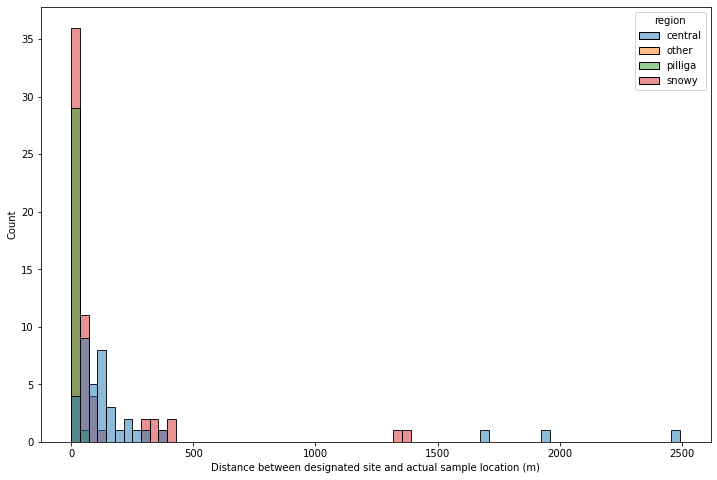

In [12]:
med_dist = gdf['dist'].median()
print(f'the median distance between the designated location (given in IAP) and the recorded sample location was {med_dist:.1f} m')
print('Also note how conscientious the Pilliga team were')
fig, ax = plt.subplots(1,1,figsize=(12,8))
x_col = 'dist'
ax = sns.histplot(x=x_col, data=gdf, hue='region')
ax.set(xlabel=labels[x_col])
plt.show()

## Sample the AFO geotiffs

It seems that all the geotiffs are all projected using the MGA zone 56 crs (EPSG:32756) regardless of what zone they are in but let's check this as we read them.

In [13]:
#crown cover
cc_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_cover-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_cover-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_cover-2021.tif',
}

gdf['afo_cc'] = read_afo(cc_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,representative,comments,geometry,region,zone,loc_cartesian,Site_Id,site_cartesian,dist,afo_cc
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,yes,None,POINT (151.28407 -33.58385),central,56,POINT (340759.370 6282663.946),EC10,POINT (340699.011 6282391.519),279.0,50.941280
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,None,None,POINT (151.28377 -33.58408),central,56,POINT (340731.620 6282637.380),EC10,POINT (340699.011 6282391.519),248.0,53.012089
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,yes,None,POINT (151.28358 -33.58432),central,56,POINT (340714.968 6282610.405),EC10,POINT (340699.011 6282391.519),219.0,36.591705
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,yes,None,POINT (151.04137 -34.16933),central,56,POINT (319470.917 6217334.192),EC11,POINT (319365.883 6217370.861),111.0,82.196129
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,yes,None,POINT (151.04147 -34.16886),central,56,POINT (319479.542 6217386.212),EC11,POINT (319365.883 6217370.861),115.0,73.356422


In [14]:
# ladder fuel density
lfd_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-ladder_fuel_density-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-ladder_fuel_density-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-ladder_fuel_density-2021.tif',
}
gdf['afo_lfd'] = read_afo(lfd_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,comments,geometry,region,zone,loc_cartesian,Site_Id,site_cartesian,dist,afo_cc,afo_lfd
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,None,POINT (151.28407 -33.58385),central,56,POINT (340759.370 6282663.946),EC10,POINT (340699.011 6282391.519),279.0,50.941280,10.934896
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,None,POINT (151.28377 -33.58408),central,56,POINT (340731.620 6282637.380),EC10,POINT (340699.011 6282391.519),248.0,53.012089,8.507341
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,None,POINT (151.28358 -33.58432),central,56,POINT (340714.968 6282610.405),EC10,POINT (340699.011 6282391.519),219.0,36.591705,15.579016
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,None,POINT (151.04137 -34.16933),central,56,POINT (319470.917 6217334.192),EC11,POINT (319365.883 6217370.861),111.0,82.196129,3.869198
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,None,POINT (151.04147 -34.16886),central,56,POINT (319479.542 6217386.212),EC11,POINT (319365.883 6217370.861),115.0,73.356422,7.731657


In [15]:
# canopy height
ch_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_height-2021.tif',
}

gdf['afo_ch'] = read_afo(ch_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,geometry,region,zone,loc_cartesian,Site_Id,site_cartesian,dist,afo_cc,afo_lfd,afo_ch
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,POINT (151.28407 -33.58385),central,56,POINT (340759.370 6282663.946),EC10,POINT (340699.011 6282391.519),279.0,50.941280,10.934896,5.625101
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,POINT (151.28377 -33.58408),central,56,POINT (340731.620 6282637.380),EC10,POINT (340699.011 6282391.519),248.0,53.012089,8.507341,6.257932
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,POINT (151.28358 -33.58432),central,56,POINT (340714.968 6282610.405),EC10,POINT (340699.011 6282391.519),219.0,36.591705,15.579016,3.823408
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,POINT (151.04137 -34.16933),central,56,POINT (319470.917 6217334.192),EC11,POINT (319365.883 6217370.861),111.0,82.196129,3.869198,9.999367
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,POINT (151.04147 -34.16886),central,56,POINT (319479.542 6217386.212),EC11,POINT (319365.883 6217370.861),115.0,73.356422,7.731657,5.684369


In [16]:
# canopy base height
cbh_paths = {
    'pilliga': 'spatial_data/Pilliga-vegetation-canopy_base_height-2021.tif',
    'central': 'spatial_data/Centralcoast-vegetation-canopy_base_height-2021.tif',
    'snowy': 'spatial_data/Southmnts-vegetation-canopy_base_height-2021.tif',
}
gdf['afo_cbh'] = read_afo(cbh_paths, gdf)
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,region,zone,loc_cartesian,Site_Id,site_cartesian,dist,afo_cc,afo_lfd,afo_ch,afo_cbh
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,central,56,POINT (340759.370 6282663.946),EC10,POINT (340699.011 6282391.519),279.0,50.941280,10.934896,5.625101,2.781175
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,central,56,POINT (340731.620 6282637.380),EC10,POINT (340699.011 6282391.519),248.0,53.012089,8.507341,6.257932,3.228979
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,central,56,POINT (340714.968 6282610.405),EC10,POINT (340699.011 6282391.519),219.0,36.591705,15.579016,3.823408,3.203048
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,central,56,POINT (319470.917 6217334.192),EC11,POINT (319365.883 6217370.861),111.0,82.196129,3.869198,9.999367,4.333815
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,central,56,POINT (319479.542 6217386.212),EC11,POINT (319365.883 6217370.861),115.0,73.356422,7.731657,5.684369,2.840926


In [17]:
# fuel loads
fuel_load_paths = {
    'pilliga': 'spatial_data/Pilliga-fuels-classes-2021-density.tif',
    'central': 'spatial_data/Centralcoast-fuels-classes-2021-density.tif',
    'snowy': 'spatial_data/Southmnts-fuels-classes-2021-density.tif',
}

strata = ['afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']

for i, stratum in enumerate(strata):
    gdf[stratum] = read_afo(fuel_load_paths, gdf, index=i)

gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,veg_type,fire_hist,loc_accuracy,litter_d_m,litter_cov,litter_load,s_fhr,...,site_cartesian,dist,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,DSF,2,4.658635,19.0,100,5.00,Moderate,...,POINT (340699.011 6282391.519),279.0,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,DSF,2,4.646899,11.0,40,2.50,Low,...,POINT (340699.011 6282391.519),248.0,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,DSF,2,4.675196,11.0,10,1.25,Low,...,POINT (340699.011 6282391.519),219.0,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,DSF,None,4.668194,24.0,80,5.00,Moderate,...,POINT (319365.883 6217370.861),111.0,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,DSF,None,4.658071,9.0,50,2.50,Low,...,POINT (319365.883 6217370.861),115.0,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005


trim the dataframe down again

In [18]:
print(list(gdf.columns.values))

['id', 'site', 'plot', 'veg_type', 'fire_hist', 'loc_accuracy', 'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_load', 's&ns_fhr', 'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_load', 'bark_type', 'bark_haz', 'bark_load', 'canopy_h_m', 'canopy_cov_m', 'representative', 'comments', 'geometry', 'region', 'zone', 'loc_cartesian', 'Site_Id', 'site_cartesian', 'dist', 'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']


In [19]:
gdf = gdf[[
    'id', 'site', 'plot', 'region', 'geometry', 'veg_type', 'fire_hist', 'loc_accuracy',
    'zone', 'loc_cartesian', 'site_cartesian', 'dist', 
    'litter_d_m', 'litter_cov', 'litter_load', 's_fhr', 
    'ns_h_m', 'ns_cov', 'ns_fhr', 'ns_fhr', 'ns_load', 's&ns_fhr', 
    'elev_h_m', 'elev_cov', 'elev_fhr', 'elev_fhr', 'elev_load', 
    'bark_type', 'bark_haz', 'bark_load', 
    'canopy_h_m', 'canopy_cov_m', 
    'representative', 
    'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark'
]]

gdf.head()

,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,zone,loc_cartesian,...,canopy_cov_m,representative,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,56,POINT (340759.370 6282663.946),...,30.0,yes,50.941280,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,56,POINT (340731.620 6282637.380),...,26.0,None,53.012089,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,56,POINT (340714.968 6282610.405),...,16.0,yes,36.591705,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,56,POINT (319470.917 6217334.192),...,60.0,yes,82.196129,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,56,POINT (319479.542 6217386.212),...,26.0,yes,73.356422,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005


In [20]:
df_corr = gdf.corr(method='pearson')
df_corr

,loc_accuracy,zone,dist,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,...,canopy_h_m,canopy_cov_m,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
loc_accuracy,1.000000,-0.088256,-0.051512,0.112384,-0.003259,-0.043230,-0.067725,0.081307,-0.013285,0.103546,...,0.168271,0.127381,-0.026431,0.015386,0.065074,0.013533,0.147237,0.138038,0.015218,0.166415
zone,-0.088256,1.000000,0.252969,0.188937,-0.118092,0.133455,0.131538,-0.203866,0.272451,0.378608,...,-0.608474,0.269861,0.711636,0.024217,0.095001,-0.270761,0.326322,0.407300,0.792626,0.477087
dist,-0.051512,0.252969,1.000000,0.008529,0.027394,0.019914,0.029299,0.102452,0.204400,0.230979,...,-0.068510,-0.137351,0.151145,0.279582,-0.090143,-0.119114,0.106023,0.121317,0.221184,0.006078
litter_d_m,0.112384,0.188937,0.008529,1.000000,0.317014,0.919460,0.224079,0.138200,0.188182,0.280819,...,0.099584,0.585697,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,-0.003259,-0.118092,0.027394,0.317014,1.000000,0.362295,0.001048,0.264071,0.014278,0.026849,...,0.180186,0.331209,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,-0.043230,0.133455,0.019914,0.919460,0.362295,1.000000,0.239996,0.167273,0.188283,0.222281,...,0.056841,0.508947,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.067725,0.131538,0.029299,0.224079,0.001048,0.239996,1.000000,0.553662,0.455636,0.460361,...,-0.222611,-0.176827,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,0.081307,-0.203866,0.102452,0.138200,0.264071,0.167273,0.553662,1.000000,0.214662,0.314499,...,0.100558,-0.038091,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,-0.013285,0.272451,0.204400,0.188182,0.014278,0.188283,0.455636,0.214662,1.000000,0.559535,...,-0.177404,-0.031426,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.103546,0.378608,0.230979,0.280819,0.026849,0.222281,0.460361,0.314499,0.559535,1.000000,...,-0.048543,0.140463,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944


just grab the rows and columns we are interested in

In [21]:
df_corr.columns.values

array(['loc_accuracy', 'zone', 'dist', 'litter_d_m', 'litter_cov',
       'litter_load', 'ns_h_m', 'ns_cov', 'ns_load', 'elev_h_m',
       'elev_cov', 'elev_load', 'bark_load', 'canopy_h_m', 'canopy_cov_m',
       'afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter',
       'afo_surface', 'afo_elevated', 'afo_bark'], dtype=object)

In [22]:
df_corr[['afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']].iloc[2:15]

,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
dist,0.151145,0.279582,-0.090143,-0.119114,0.106023,0.121317,0.221184,0.006078
litter_d_m,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944
elev_cov,0.084107,0.255311,0.059883,-0.063541,0.113997,0.143060,0.178040,0.221774
elev_load,0.012920,0.182625,-0.046872,-0.117747,0.057657,0.075452,0.163522,0.069148


AFO Crown Cover % v Mean canopy cover (%)
stats:
pearson r: 0.57 	 r sq: 0.33 	 p: 0.00


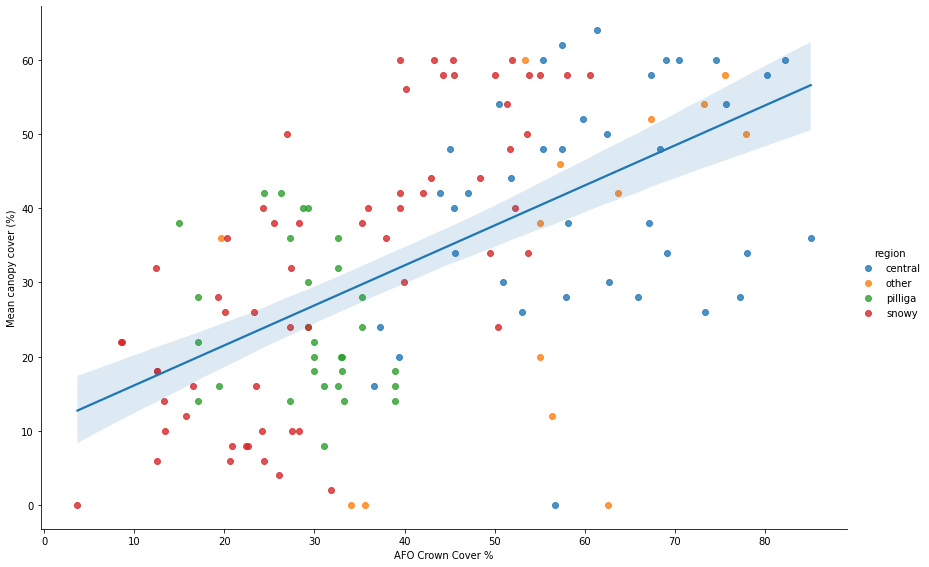

central stats:
pearson r: 0.33 	 r sq: 0.11 	 p: 0.04
other stats:
pearson r: 0.52 	 r sq: 0.27 	 p: 0.06
pilliga stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.16
snowy stats:
pearson r: 0.76 	 r sq: 0.57 	 p: 0.00


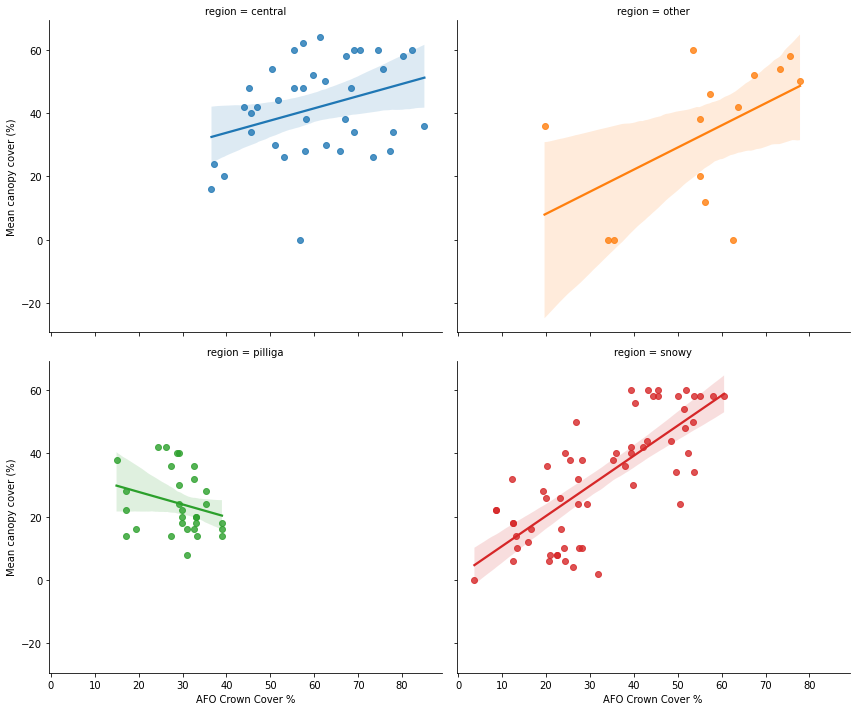

DSF stats:
pearson r: 0.62 	 r sq: 0.38 	 p: 0.00
Heath stats:
pearson r: 0.34 	 r sq: 0.12 	 p: 0.51
WSF stats:
pearson r: 0.43 	 r sq: 0.18 	 p: 0.08


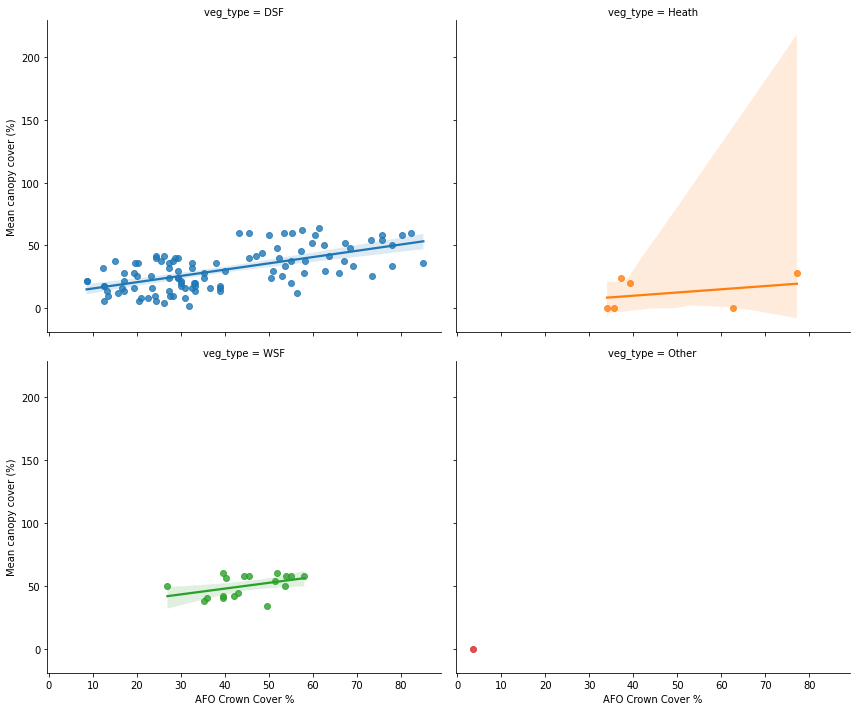

In [23]:
x = 'afo_cc'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Height (m) v Mean canopy height (m)
stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.00


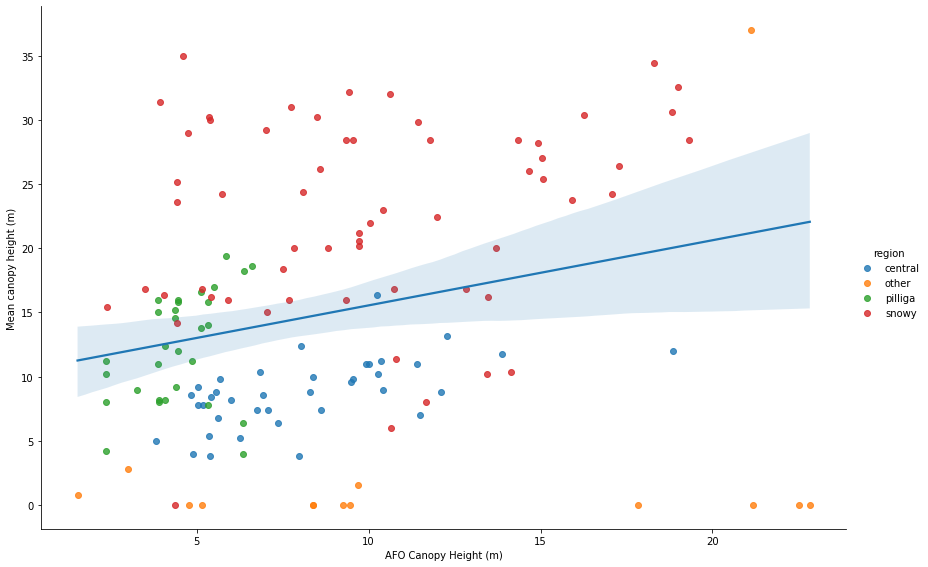

central stats:
pearson r: 0.58 	 r sq: 0.34 	 p: 0.00
other stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.27
pilliga stats:
pearson r: 0.38 	 r sq: 0.14 	 p: 0.04
snowy stats:
pearson r: 0.23 	 r sq: 0.05 	 p: 0.07


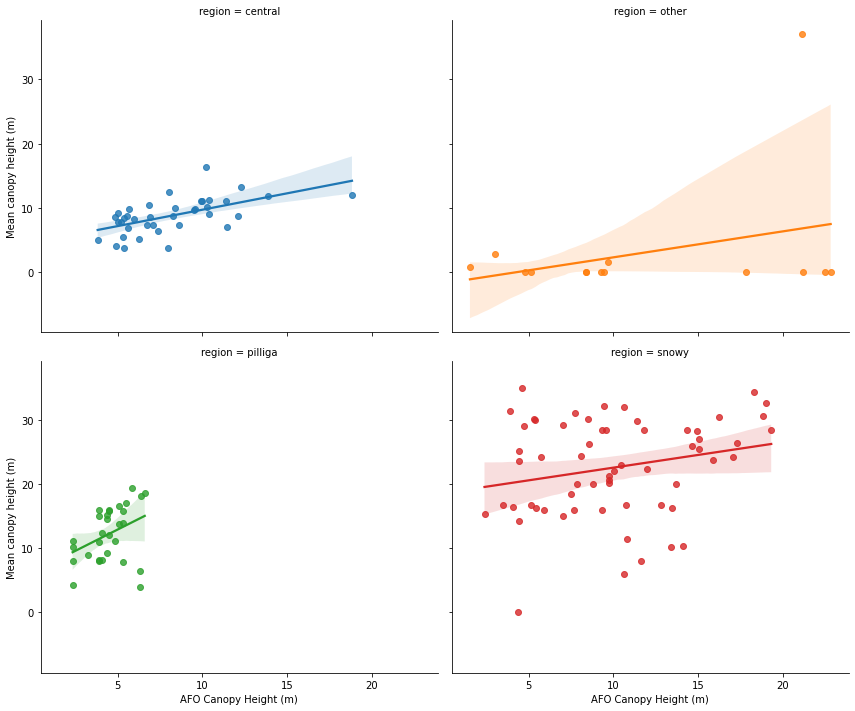

DSF stats:
pearson r: 0.06 	 r sq: 0.00 	 p: 0.55
Heath stats:
pearson r: 0.40 	 r sq: 0.16 	 p: 0.43
WSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.01


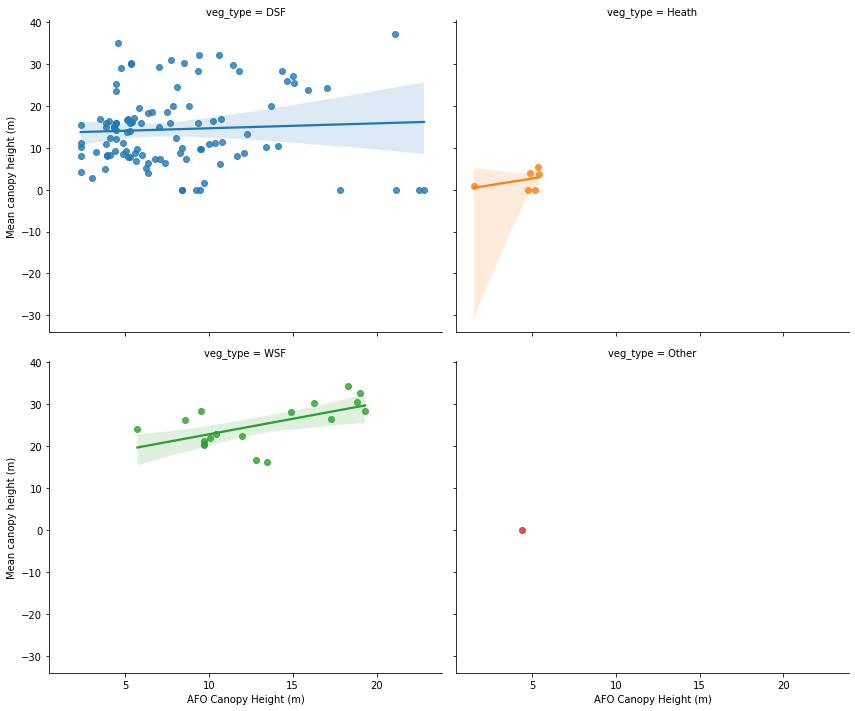

In [24]:
x = 'afo_ch'
y = 'canopy_h_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Height (m) v Mean canopy cover (%)
stats:
pearson r: 0.52 	 r sq: 0.27 	 p: 0.00


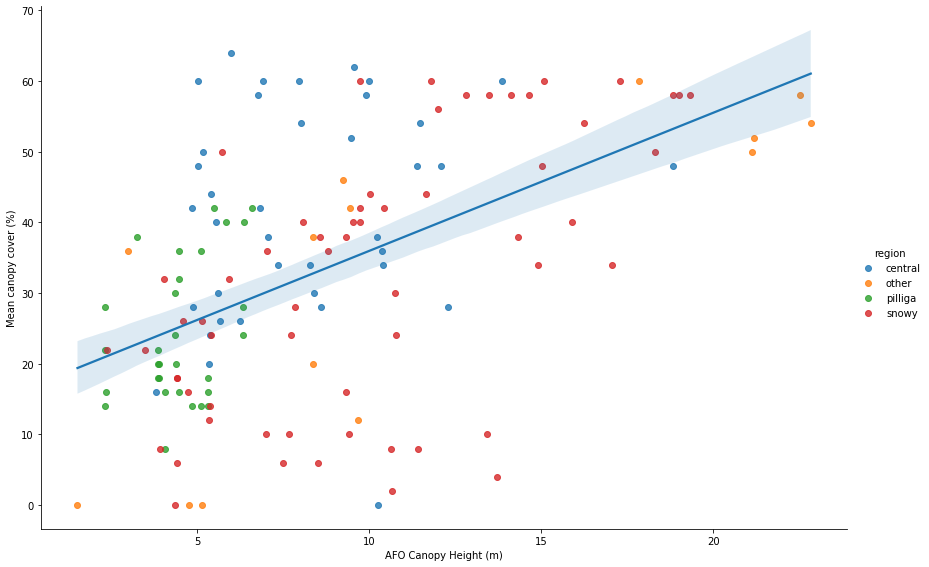

central stats:
pearson r: 0.20 	 r sq: 0.04 	 p: 0.24
other stats:
pearson r: 0.79 	 r sq: 0.63 	 p: 0.00
pilliga stats:
pearson r: 0.38 	 r sq: 0.14 	 p: 0.04
snowy stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.00


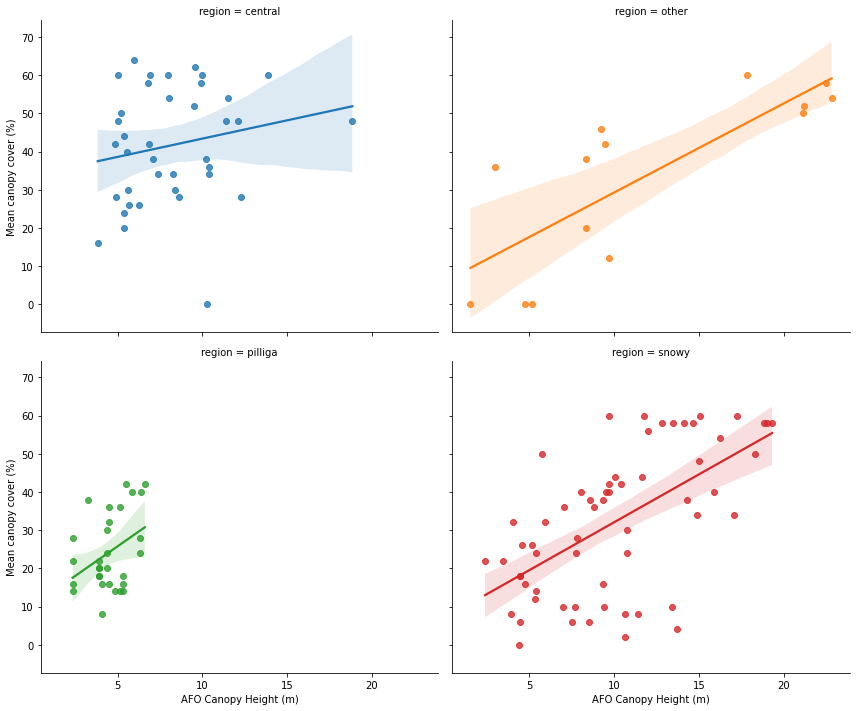

DSF stats:
pearson r: 0.44 	 r sq: 0.19 	 p: 0.00
Heath stats:
pearson r: 0.49 	 r sq: 0.24 	 p: 0.33
WSF stats:
pearson r: 0.50 	 r sq: 0.25 	 p: 0.03


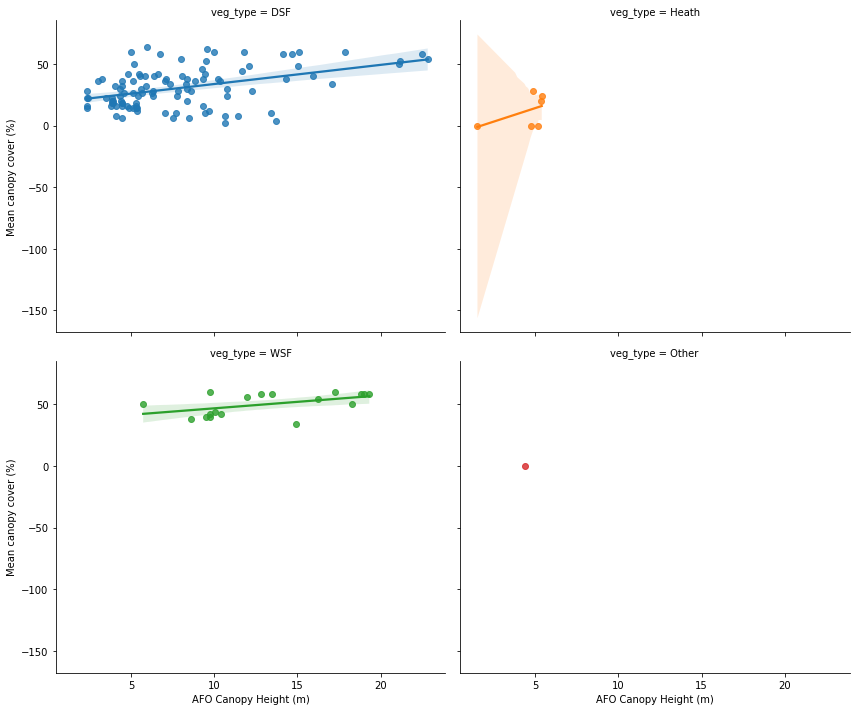

In [25]:
x = 'afo_ch'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Base Height (m) v Mean canopy height (m)
stats:
pearson r: 0.45 	 r sq: 0.21 	 p: 0.00


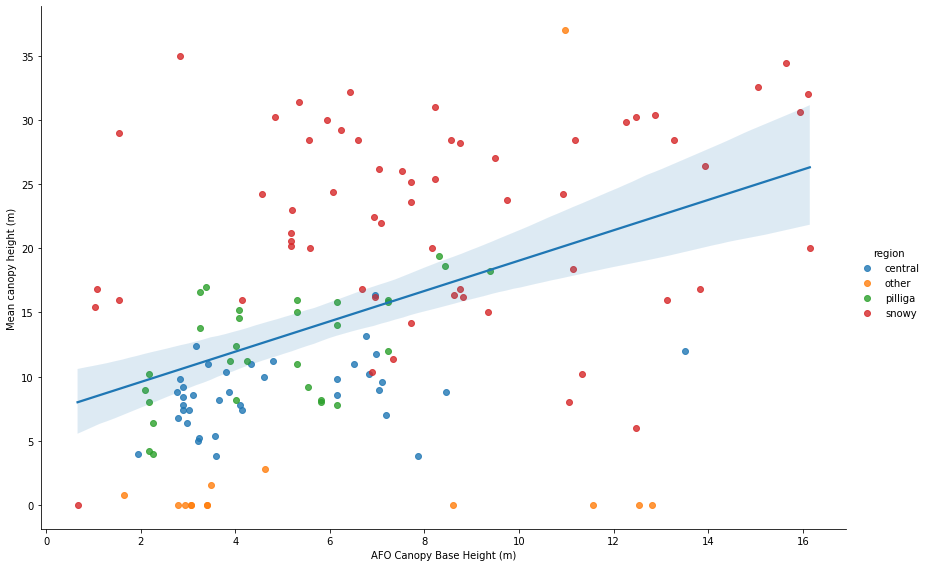

central stats:
pearson r: 0.39 	 r sq: 0.15 	 p: 0.02
other stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.27
pilliga stats:
pearson r: 0.59 	 r sq: 0.35 	 p: 0.00
snowy stats:
pearson r: 0.20 	 r sq: 0.04 	 p: 0.12


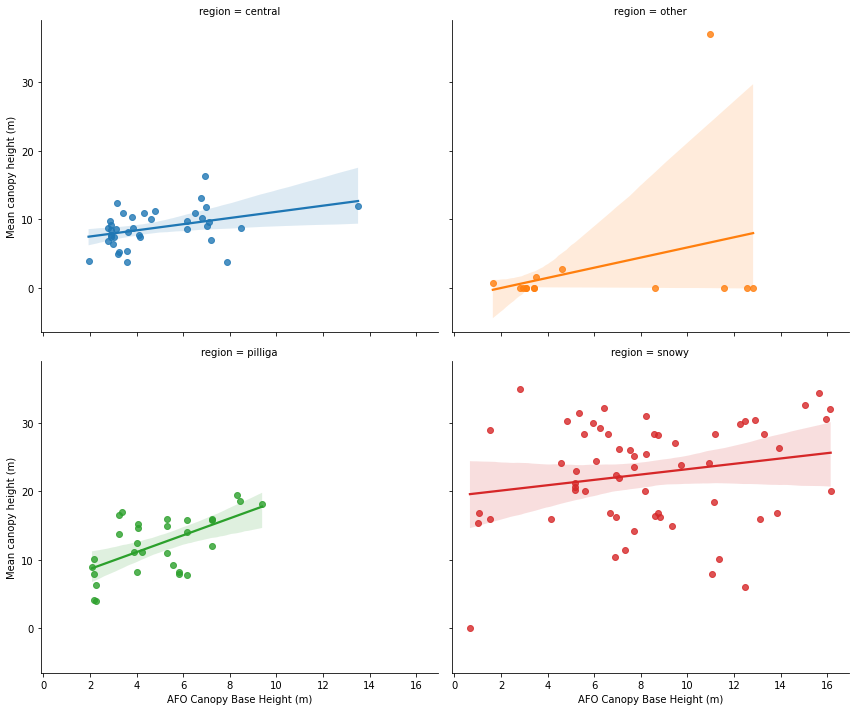

DSF stats:
pearson r: 0.32 	 r sq: 0.11 	 p: 0.00
Heath stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.64
WSF stats:
pearson r: 0.81 	 r sq: 0.65 	 p: 0.00


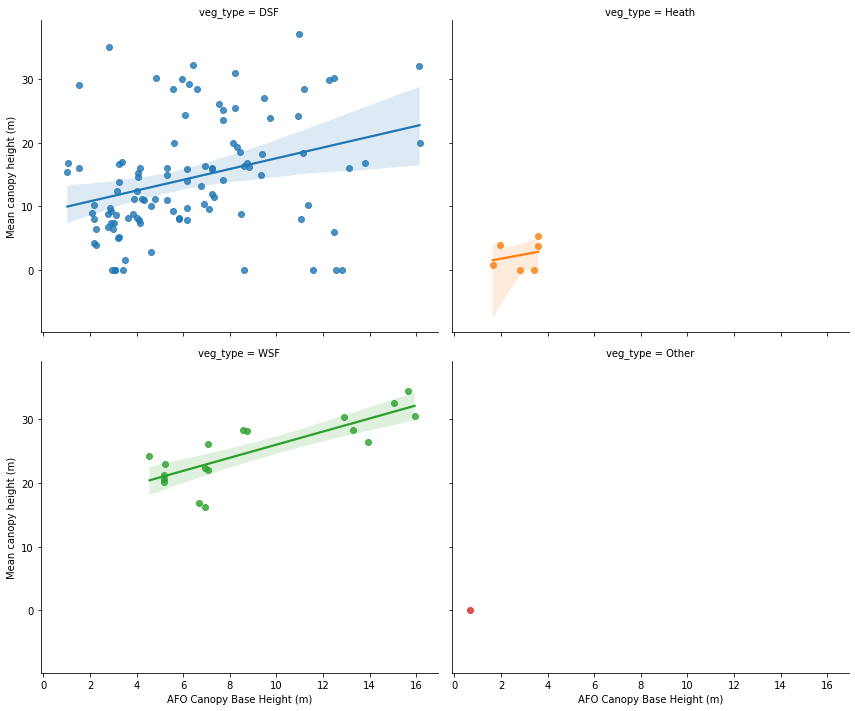

In [26]:
x = 'afo_cbh'
y = 'canopy_h_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO litter fuel load (t/ha) v Mean litter depth (mm)
stats:
pearson r: 0.49 	 r sq: 0.24 	 p: 0.00


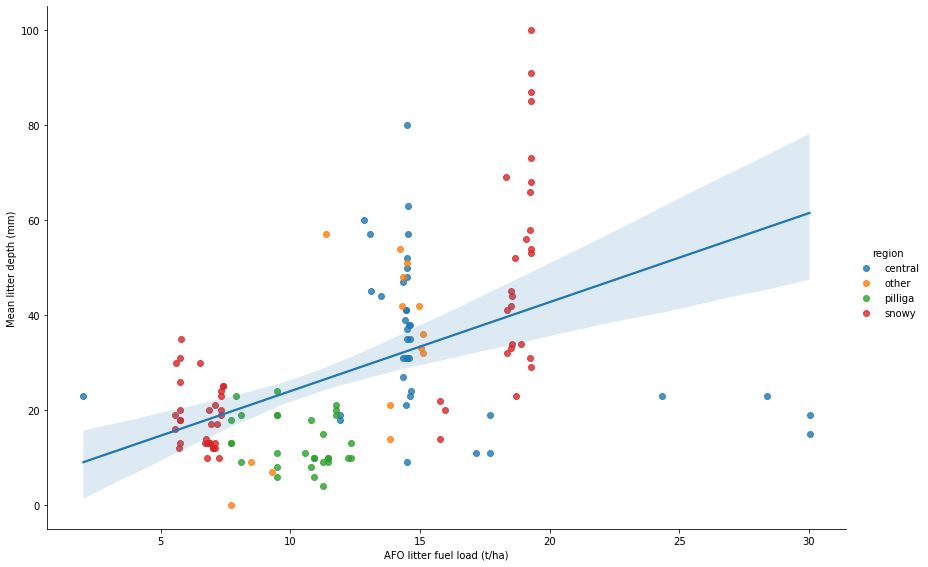

central stats:
pearson r: -0.29 	 r sq: 0.09 	 p: 0.08
other stats:
pearson r: 0.65 	 r sq: 0.43 	 p: 0.01
pilliga stats:
pearson r: -0.25 	 r sq: 0.06 	 p: 0.18
snowy stats:
pearson r: 0.74 	 r sq: 0.54 	 p: 0.00


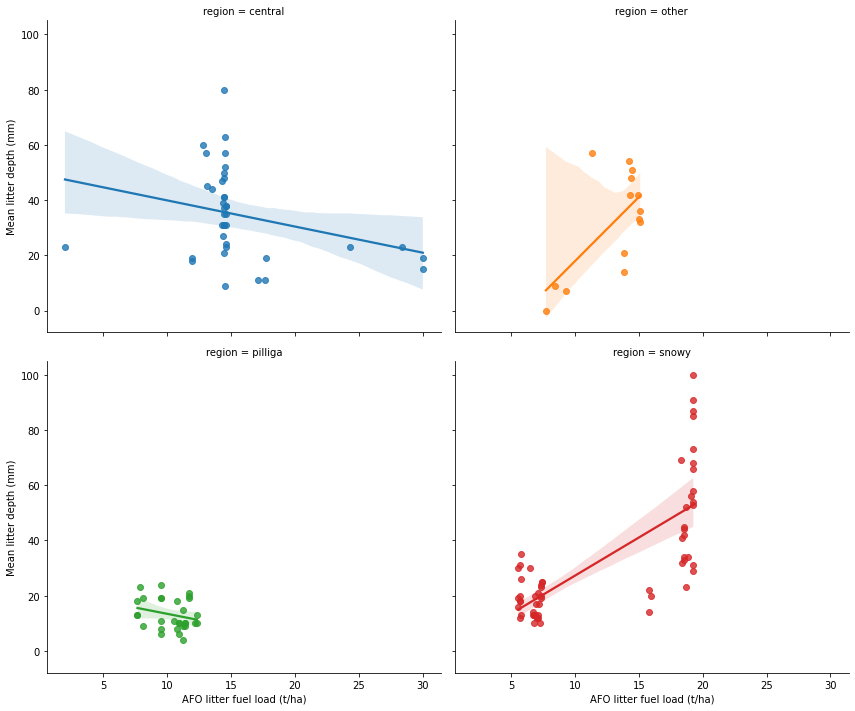

DSF stats:
pearson r: 0.42 	 r sq: 0.18 	 p: 0.00
Heath stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.03
WSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.01


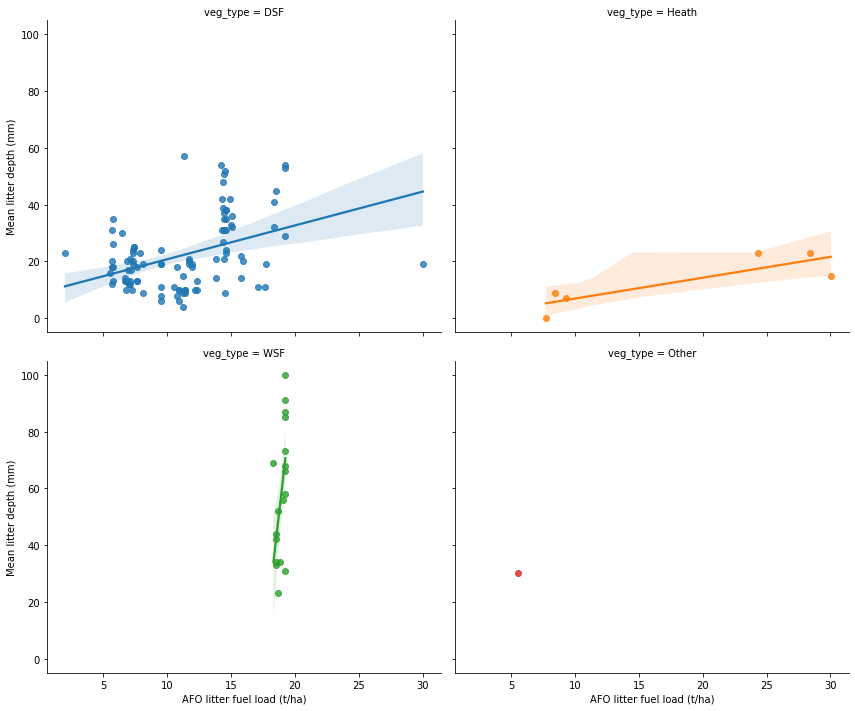

In [27]:
x = 'afo_litter'
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO litter fuel load (t/ha) v Litter fuel load (t/ha)
stats:
pearson r: 0.41 	 r sq: 0.17 	 p: 0.00


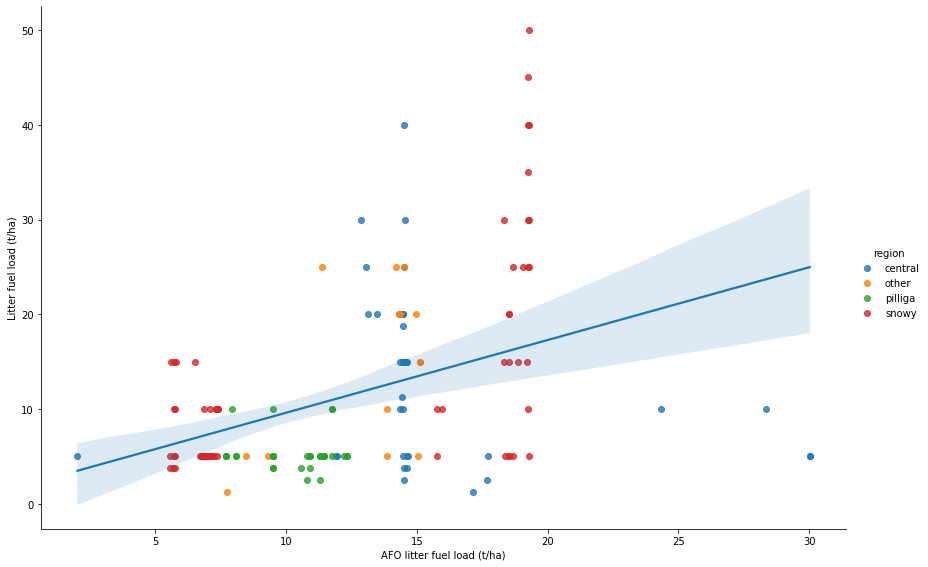

central stats:
pearson r: -0.20 	 r sq: 0.04 	 p: 0.23
other stats:
pearson r: 0.52 	 r sq: 0.27 	 p: 0.05
pilliga stats:
pearson r: -0.05 	 r sq: 0.00 	 p: 0.80
snowy stats:
pearson r: 0.62 	 r sq: 0.38 	 p: 0.00


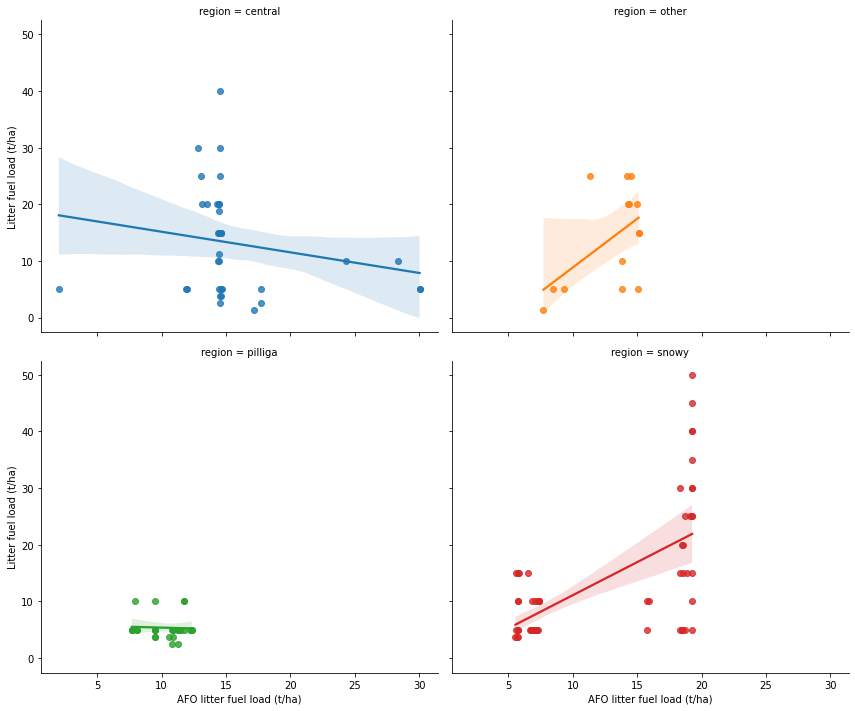

DSF stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.01
Heath stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.14
WSF stats:
pearson r: 0.61 	 r sq: 0.38 	 p: 0.01


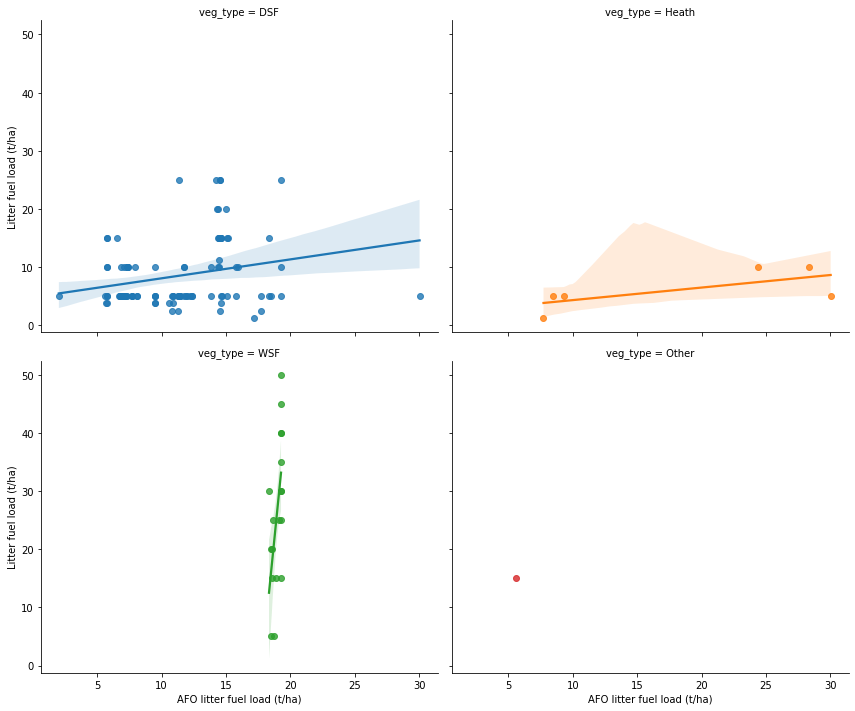

In [28]:
x = 'afo_litter'
y = 'litter_load'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v Mean litter depth (mm)
stats:
pearson r: 0.51 	 r sq: 0.26 	 p: 0.00


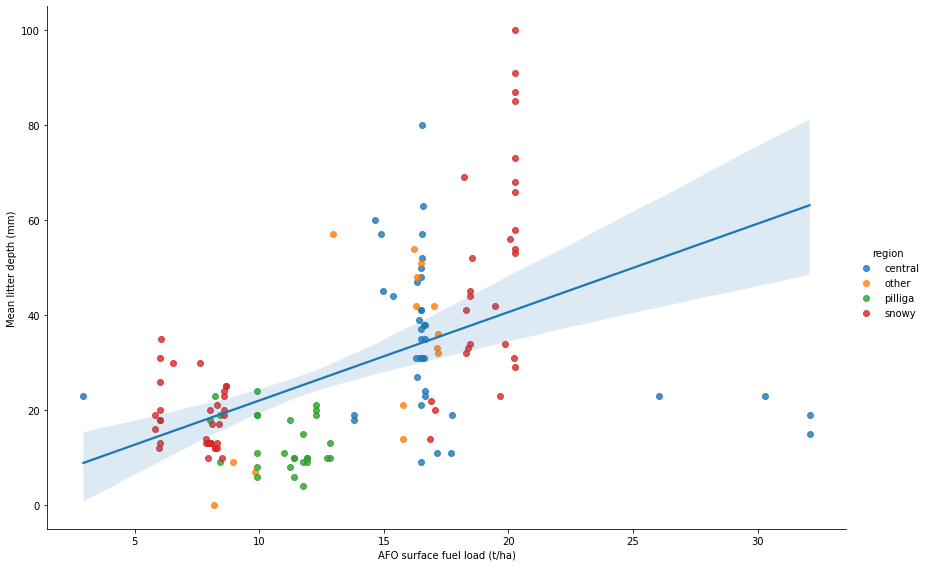

central stats:
pearson r: -0.24 	 r sq: 0.06 	 p: 0.14
other stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.01
pilliga stats:
pearson r: -0.25 	 r sq: 0.06 	 p: 0.18
snowy stats:
pearson r: 0.74 	 r sq: 0.54 	 p: 0.00


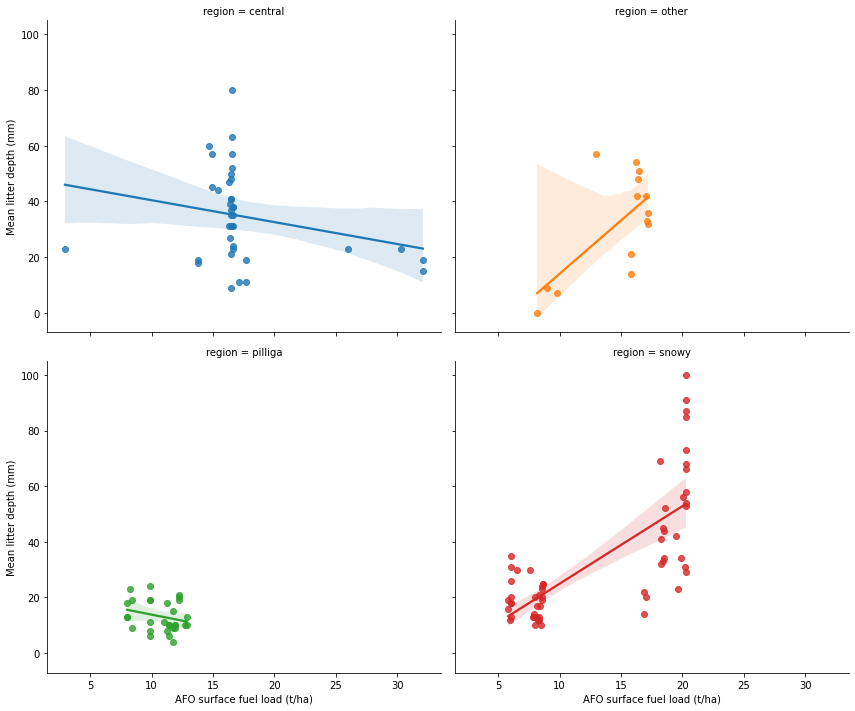

DSF stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.00
Heath stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.03
WSF stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.05


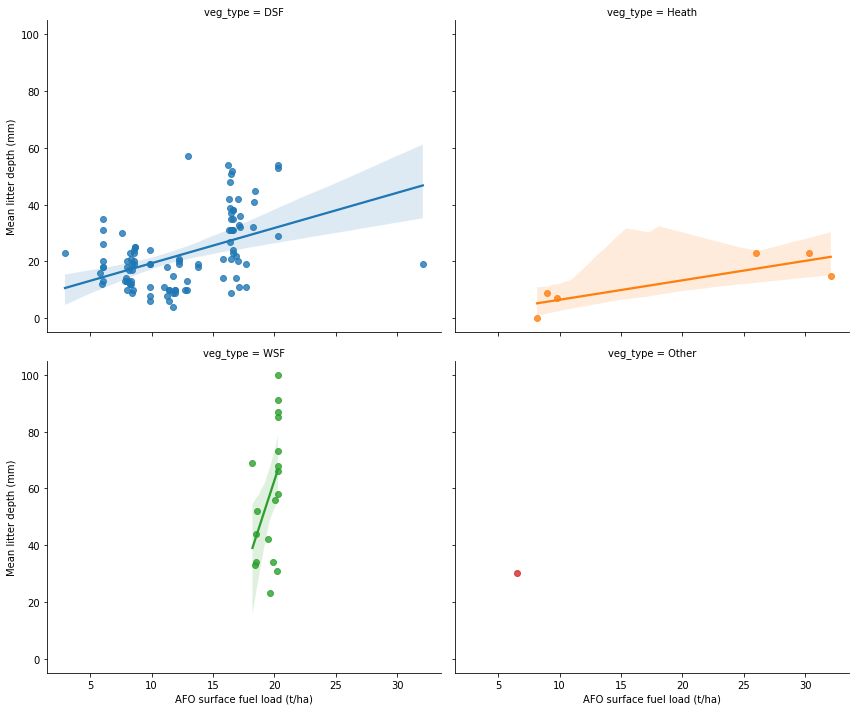

In [29]:
x = 'afo_surface'
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v Mean canopy cover (%)
stats:
pearson r: 0.56 	 r sq: 0.31 	 p: 0.00


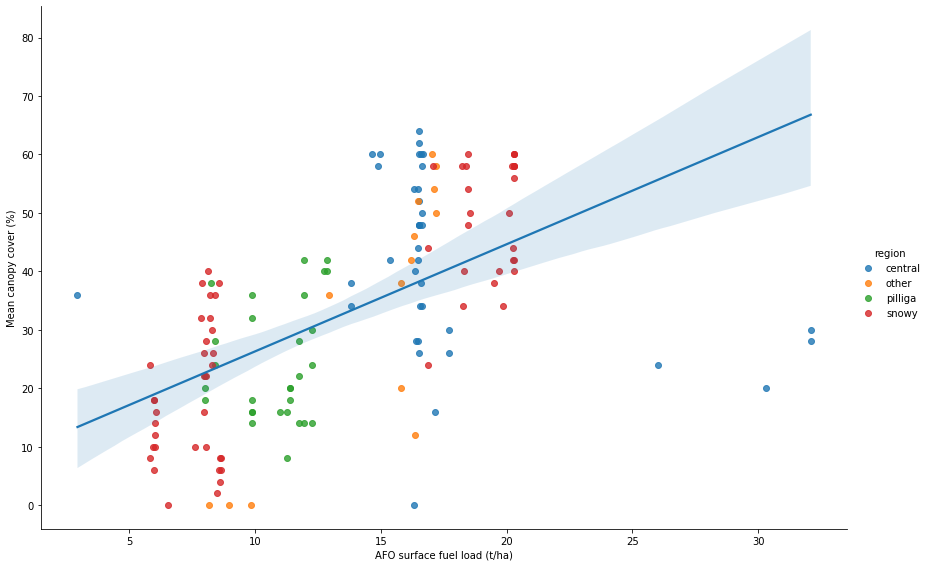

central stats:
pearson r: -0.31 	 r sq: 0.10 	 p: 0.06
other stats:
pearson r: 0.84 	 r sq: 0.70 	 p: 0.00
pilliga stats:
pearson r: 0.19 	 r sq: 0.04 	 p: 0.30
snowy stats:
pearson r: 0.82 	 r sq: 0.68 	 p: 0.00


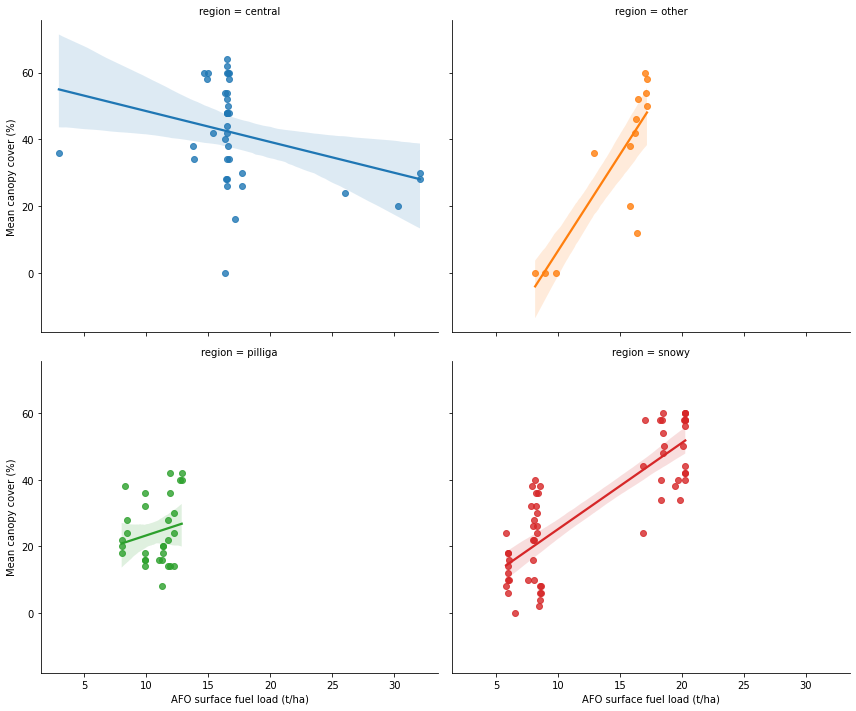

DSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.00
Heath stats:
pearson r: 0.98 	 r sq: 0.95 	 p: 0.00
WSF stats:
pearson r: -0.29 	 r sq: 0.08 	 p: 0.25


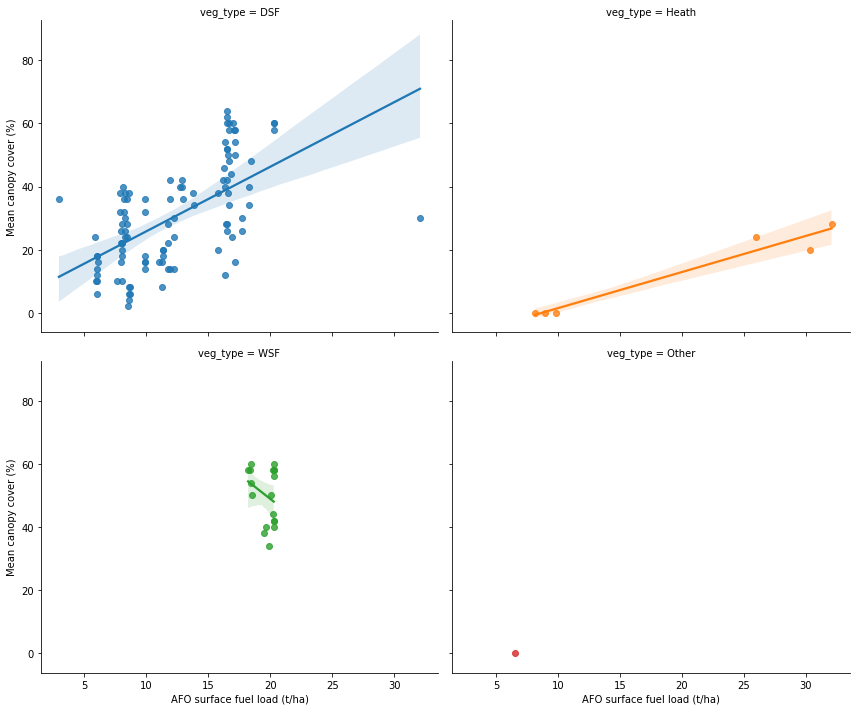

In [30]:
x = 'afo_surface'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO elevated fuel  load (t/ha) v Elevated fuel load (t/ha)
stats:
pearson r: 0.16 	 r sq: 0.03 	 p: 0.05


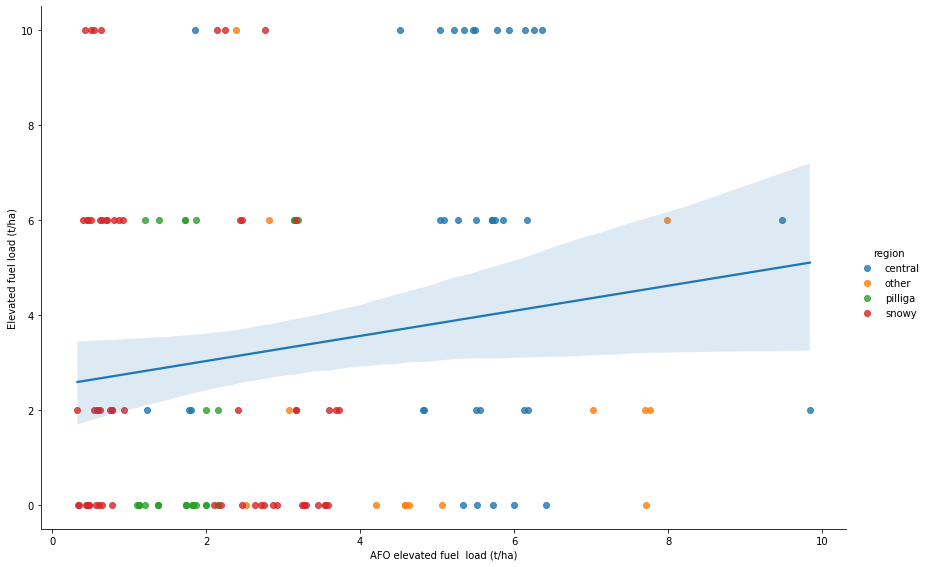

central stats:
pearson r: 0.03 	 r sq: 0.00 	 p: 0.84
other stats:
pearson r: -0.17 	 r sq: 0.03 	 p: 0.55
pilliga stats:
pearson r: 0.43 	 r sq: 0.19 	 p: 0.02
snowy stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.04


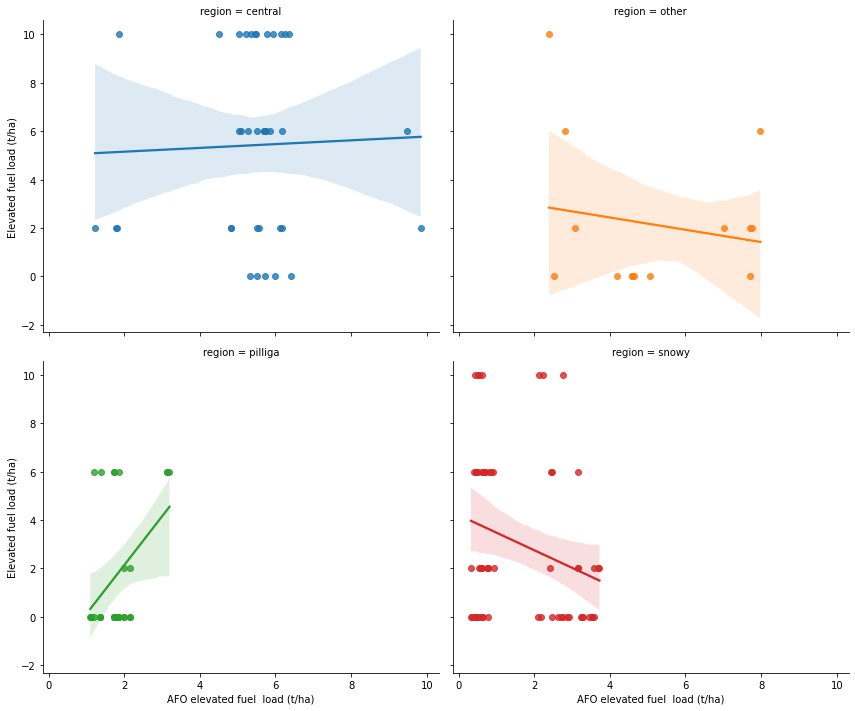

DSF stats:
pearson r: -0.00 	 r sq: 0.00 	 p: 0.98
Heath stats:
pearson r: 0.19 	 r sq: 0.03 	 p: 0.72
WSF stats:
pearson r: -0.54 	 r sq: 0.29 	 p: 0.02


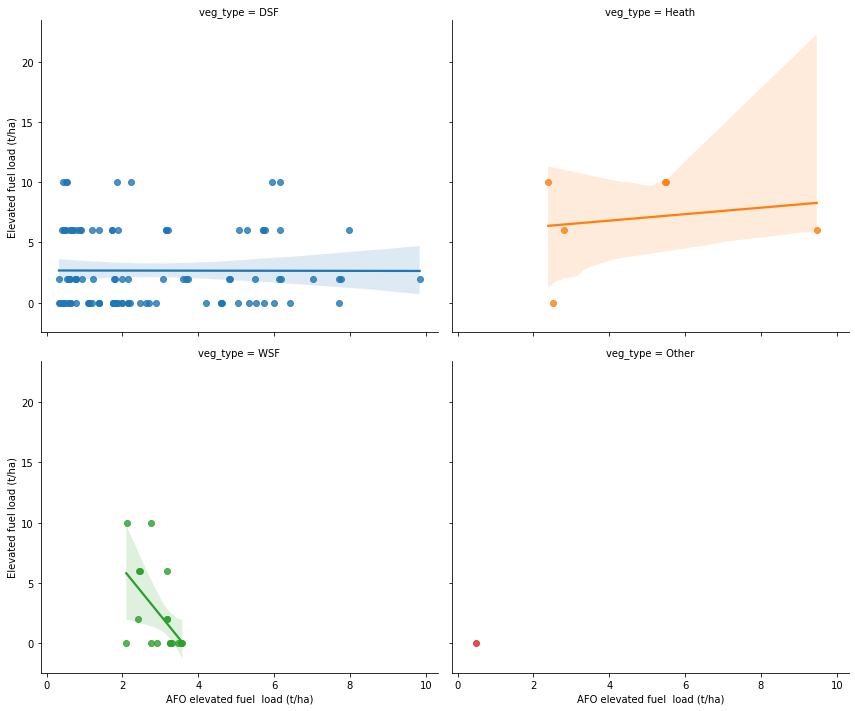

In [31]:
x = 'afo_elevated'
y = 'elev_load'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO bark fuel load (t/ha) v Mean litter depth (mm)
stats:
pearson r: 0.69 	 r sq: 0.48 	 p: 0.00


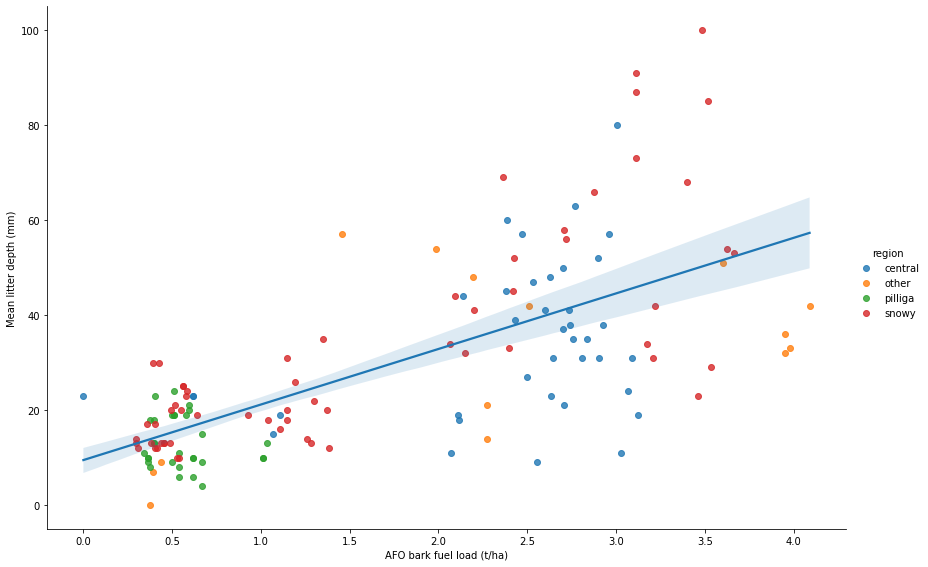

central stats:
pearson r: 0.35 	 r sq: 0.12 	 p: 0.03
other stats:
pearson r: 0.52 	 r sq: 0.28 	 p: 0.05
pilliga stats:
pearson r: -0.16 	 r sq: 0.03 	 p: 0.39
snowy stats:
pearson r: 0.78 	 r sq: 0.61 	 p: 0.00


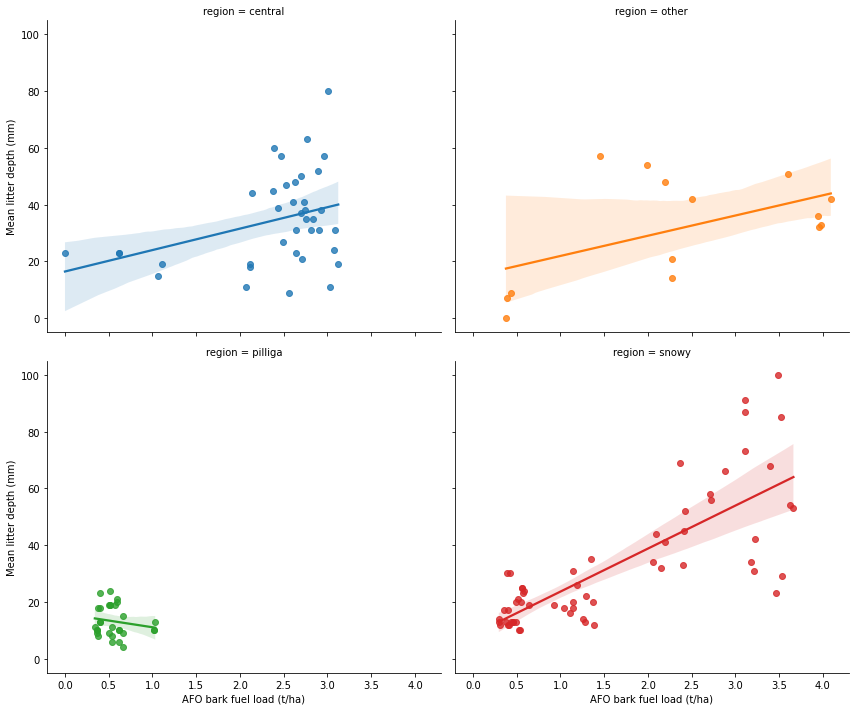

DSF stats:
pearson r: 0.66 	 r sq: 0.44 	 p: 0.00
Heath stats:
pearson r: 0.51 	 r sq: 0.26 	 p: 0.30
WSF stats:
pearson r: 0.34 	 r sq: 0.12 	 p: 0.17


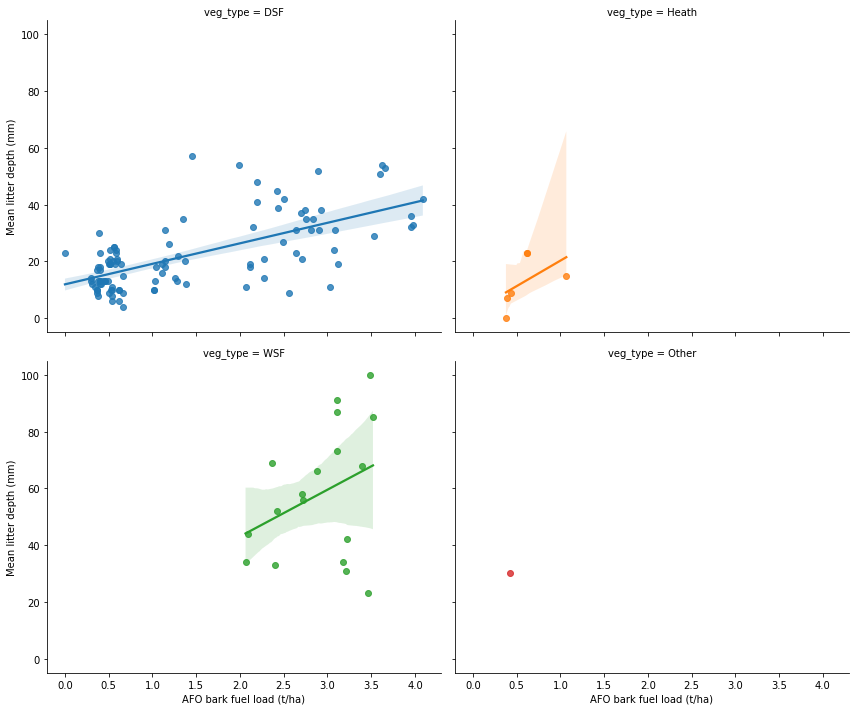

In [32]:
x = 'afo_bark'
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO bark fuel load (t/ha) v Litter fuel load (t/ha)
stats:
pearson r: 0.57 	 r sq: 0.32 	 p: 0.00


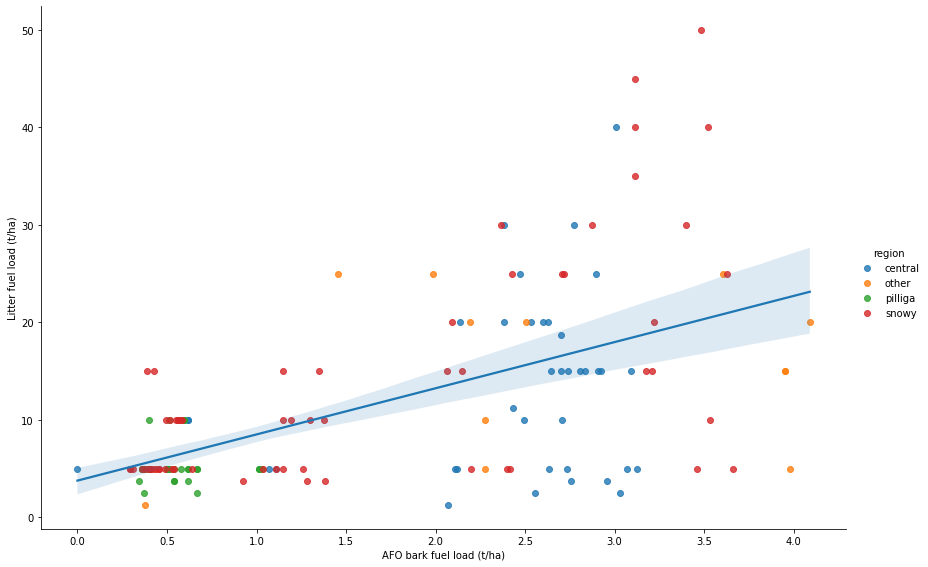

central stats:
pearson r: 0.26 	 r sq: 0.07 	 p: 0.11
other stats:
pearson r: 0.39 	 r sq: 0.15 	 p: 0.17
pilliga stats:
pearson r: -0.02 	 r sq: 0.00 	 p: 0.94
snowy stats:
pearson r: 0.66 	 r sq: 0.43 	 p: 0.00


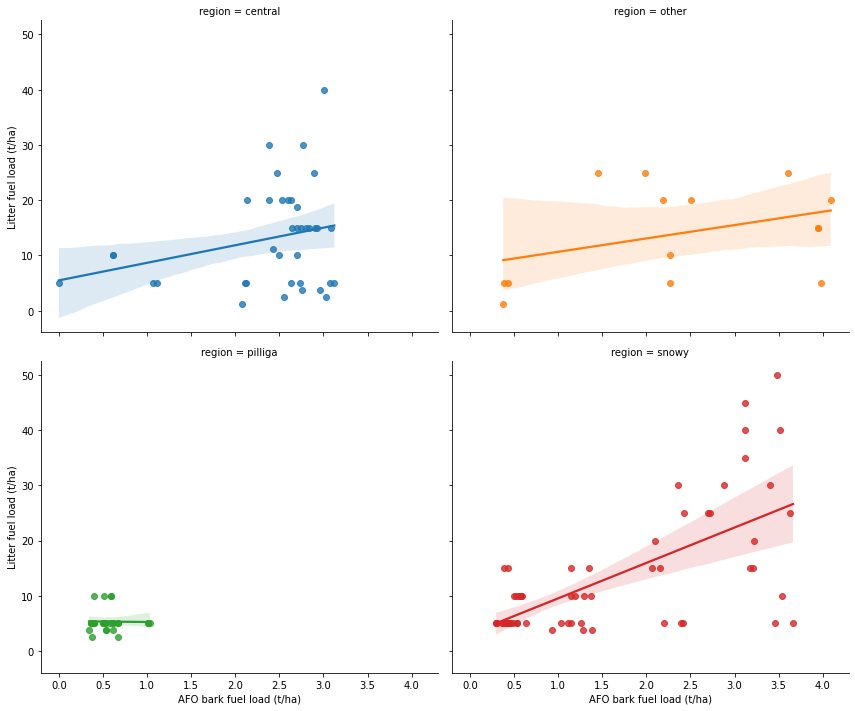

DSF stats:
pearson r: 0.49 	 r sq: 0.24 	 p: 0.00
Heath stats:
pearson r: 0.25 	 r sq: 0.06 	 p: 0.63
WSF stats:
pearson r: 0.35 	 r sq: 0.12 	 p: 0.15


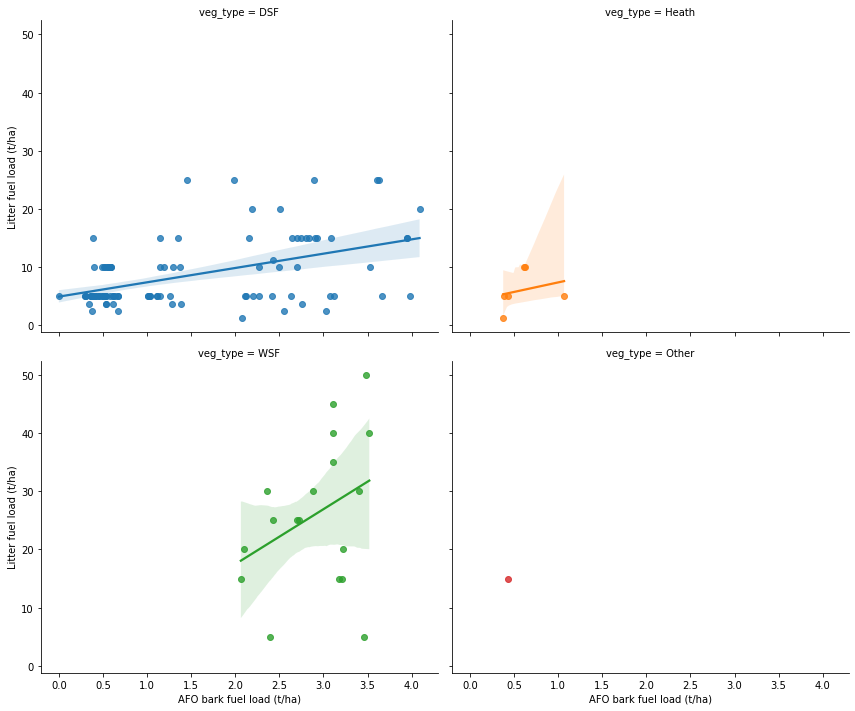

In [33]:
x = 'afo_bark'
y = 'litter_load'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO bark fuel load (t/ha) v Mean canopy cover (%)
stats:
pearson r: 0.70 	 r sq: 0.48 	 p: 0.00


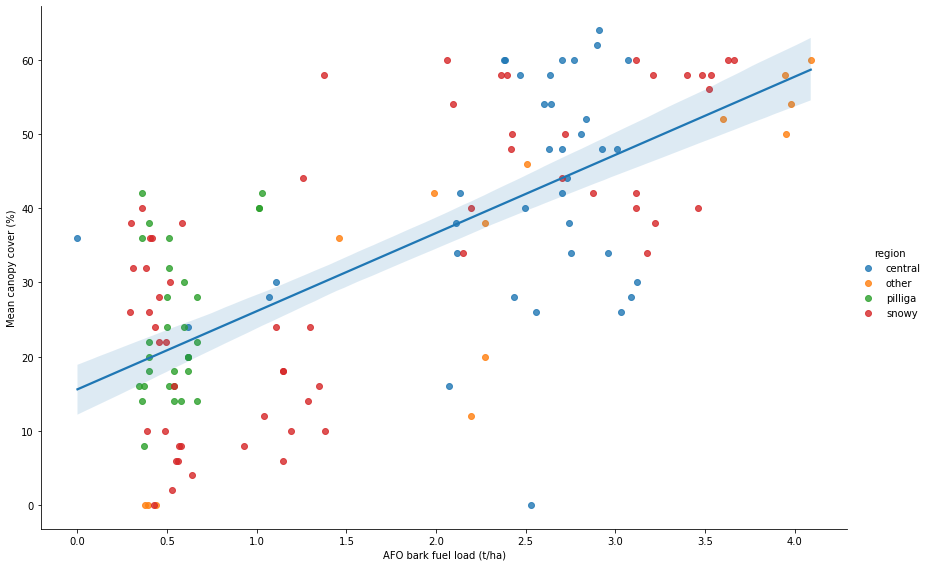

central stats:
pearson r: 0.38 	 r sq: 0.14 	 p: 0.02
other stats:
pearson r: 0.90 	 r sq: 0.82 	 p: 0.00
pilliga stats:
pearson r: 0.43 	 r sq: 0.18 	 p: 0.02
snowy stats:
pearson r: 0.72 	 r sq: 0.52 	 p: 0.00


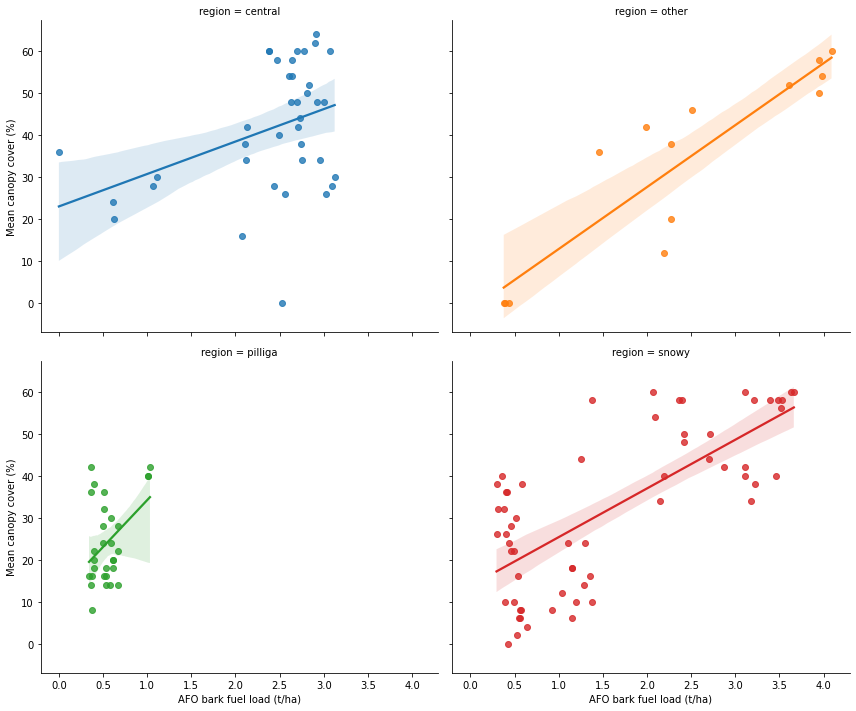

DSF stats:
pearson r: 0.66 	 r sq: 0.44 	 p: 0.00
Heath stats:
pearson r: 0.86 	 r sq: 0.74 	 p: 0.03
WSF stats:
pearson r: -0.27 	 r sq: 0.07 	 p: 0.28


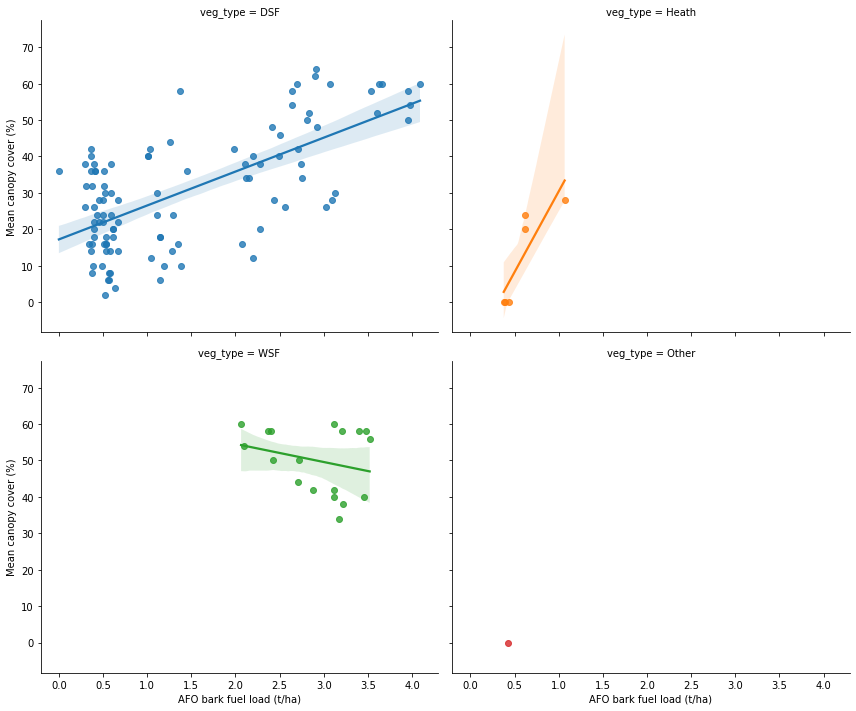

In [34]:
x = 'afo_bark'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

In [35]:
gdf['afo_cc_off'] = read_afo(cc_paths, gdf, offset=20)
labels['afo_cc_off'] = 'AFO Canopy Cover offset 20 m'
gdf['afo_ch_off'] = read_afo(ch_paths, gdf, offset=20)
labels['afo_ch_off'] = 'AFO Canopy height offset 20 m'
gdf['afo_surface_off'] = read_afo(fuel_load_paths, gdf, offset=20, index=1)
labels['afo_surface_off'] = 'AFO Surface fuel load offset 20 m'
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,zone,loc_cartesian,...,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark,afo_cc_off,afo_ch_off,afo_surface_off
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,56,POINT (340759.370 6282663.946),...,10.934896,5.625101,2.781175,17.716690,17.716690,1.855503,3.123432,47.983017,4.949597,17.553732
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,56,POINT (340731.620 6282637.380),...,8.507341,6.257932,3.228979,17.689646,17.689646,1.800139,3.030236,55.959557,6.806909,17.474041
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,56,POINT (340714.968 6282610.405),...,15.579016,3.823408,3.203048,17.148125,17.148125,1.230490,2.071327,20.561842,1.744455,15.179890
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,56,POINT (319470.917 6217334.192),...,3.869198,9.999367,4.333815,14.651359,16.660486,6.413480,3.069542,81.923386,10.693882,16.767370
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,56,POINT (319479.542 6217386.212),...,7.731657,5.684369,2.840926,14.508380,16.497902,5.340499,2.556005,83.468933,7.897730,16.324308


AFO Crown Cover % v AFO Canopy Cover offset 20 m
stats:
pearson r: 0.84 	 r sq: 0.71 	 p: 0.00


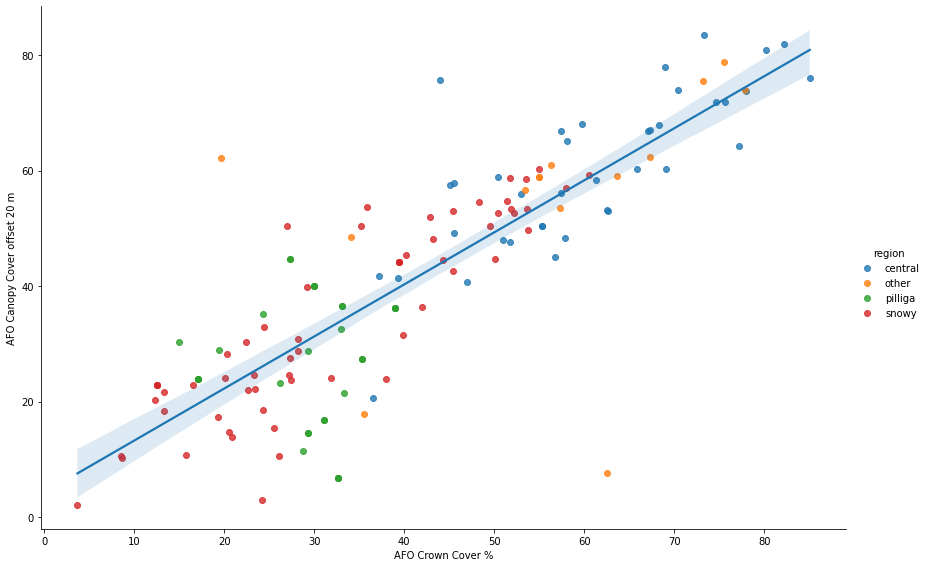

central stats:
pearson r: 0.77 	 r sq: 0.60 	 p: 0.00
other stats:
pearson r: 0.38 	 r sq: 0.15 	 p: 0.18
pilliga stats:
pearson r: 0.04 	 r sq: 0.00 	 p: 0.82
snowy stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.00


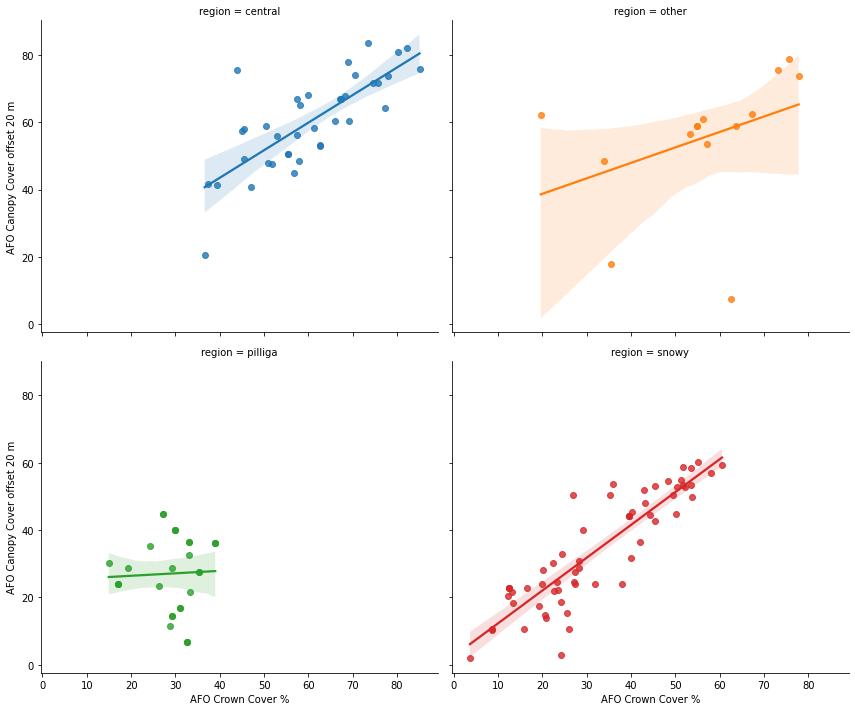

DSF stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.00
Heath stats:
pearson r: 0.19 	 r sq: 0.04 	 p: 0.72
WSF stats:
pearson r: 0.51 	 r sq: 0.26 	 p: 0.03


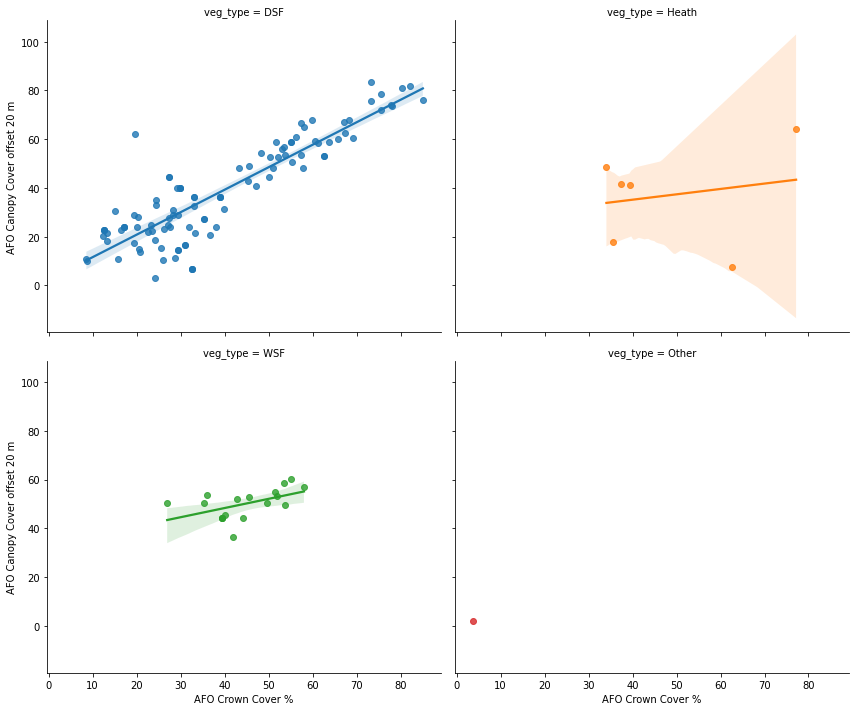

In [36]:
x = 'afo_cc'
y = 'afo_cc_off'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO Canopy Height (m) v AFO Canopy height offset 20 m
stats:
pearson r: 0.84 	 r sq: 0.70 	 p: 0.00


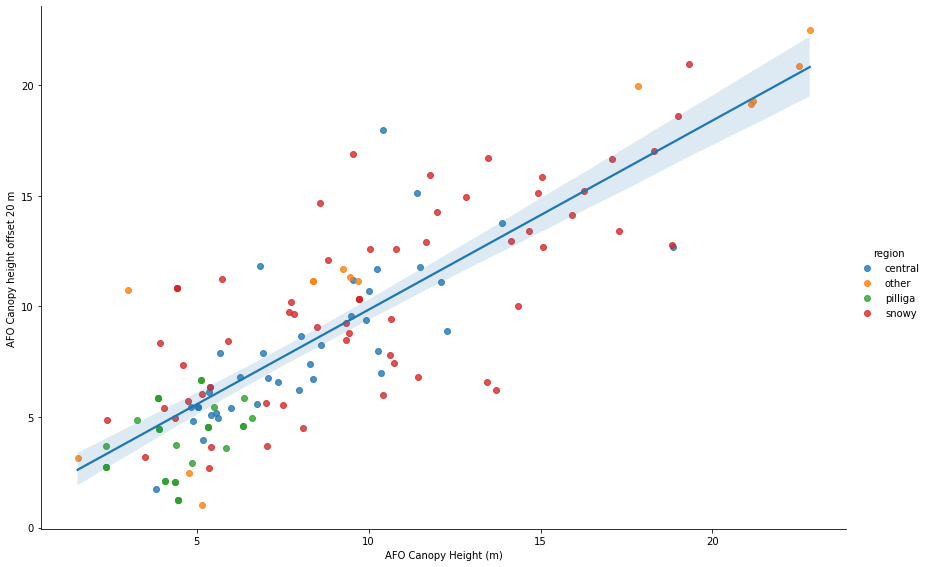

central stats:
pearson r: 0.75 	 r sq: 0.57 	 p: 0.00
other stats:
pearson r: 0.92 	 r sq: 0.84 	 p: 0.00
pilliga stats:
pearson r: 0.33 	 r sq: 0.11 	 p: 0.08
snowy stats:
pearson r: 0.72 	 r sq: 0.52 	 p: 0.00


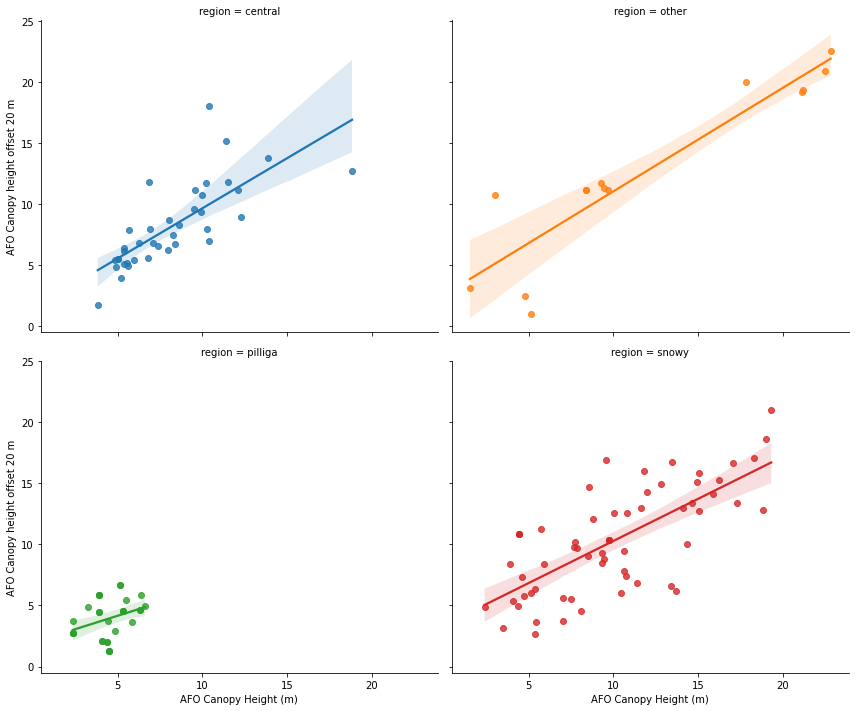

DSF stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.00
Heath stats:
pearson r: 0.28 	 r sq: 0.08 	 p: 0.59
WSF stats:
pearson r: 0.60 	 r sq: 0.36 	 p: 0.01


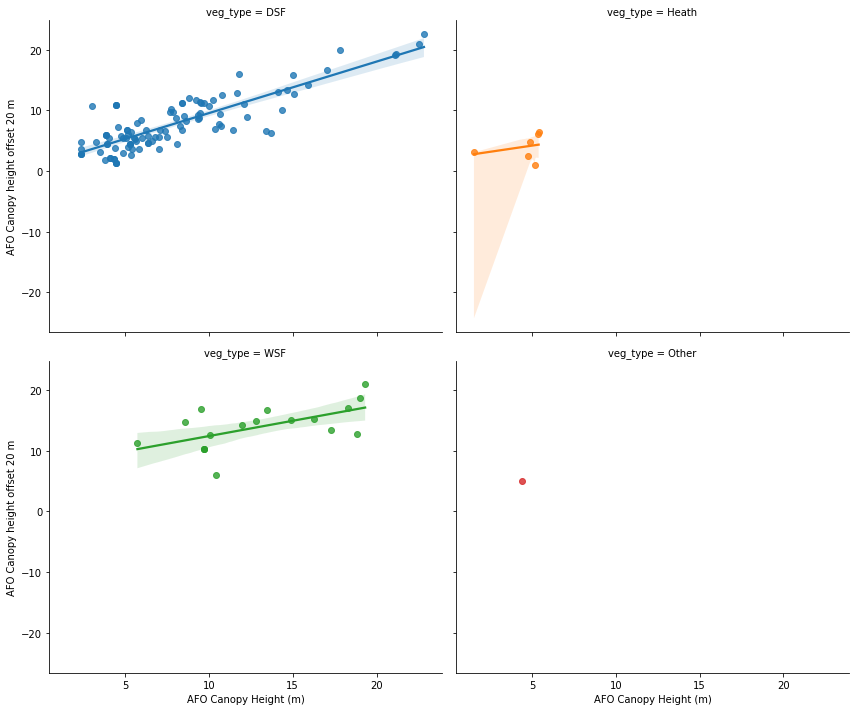

In [37]:
x = 'afo_ch'
y = 'afo_ch_off'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v AFO Surface fuel load offset 20 m
stats:
pearson r: 0.90 	 r sq: 0.81 	 p: 0.00


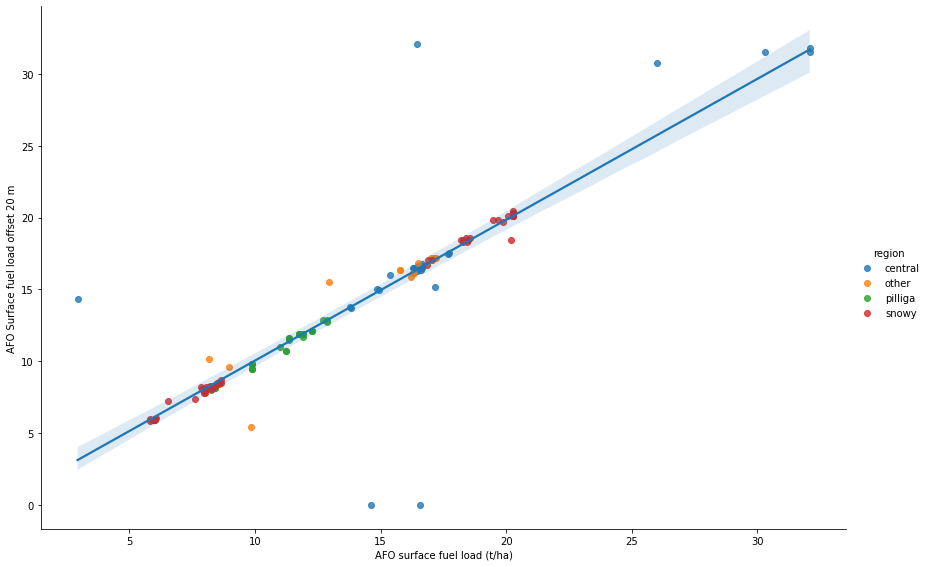

central stats:
pearson r: 0.69 	 r sq: 0.47 	 p: 0.00
other stats:
pearson r: 0.91 	 r sq: 0.82 	 p: 0.00
pilliga stats:
pearson r: 0.99 	 r sq: 0.98 	 p: 0.00
snowy stats:
pearson r: 1.00 	 r sq: 1.00 	 p: 0.00


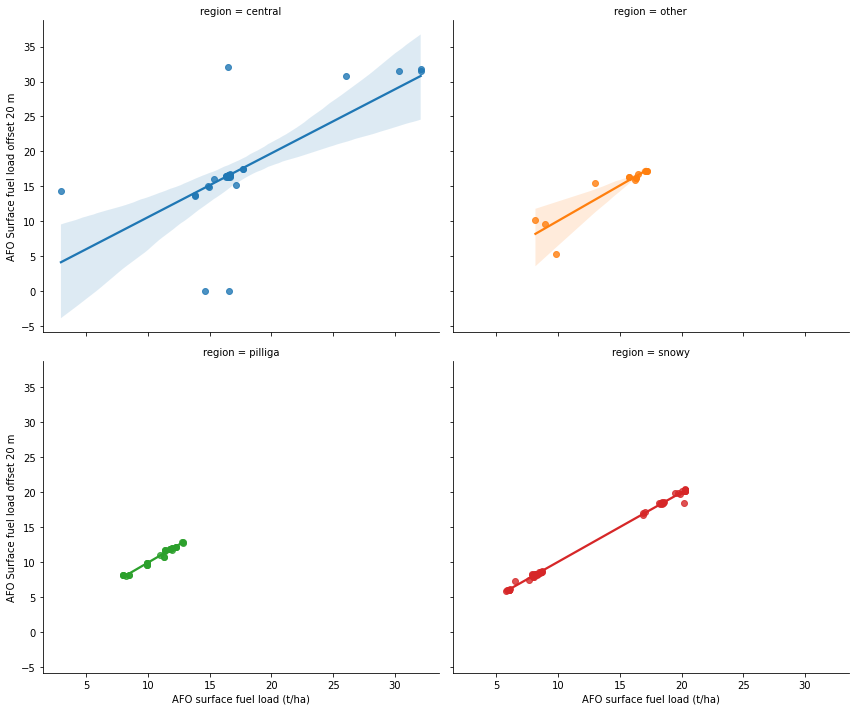

DSF stats:
pearson r: 0.92 	 r sq: 0.85 	 p: 0.00
Heath stats:
pearson r: 0.97 	 r sq: 0.95 	 p: 0.00
WSF stats:
pearson r: 0.85 	 r sq: 0.73 	 p: 0.00


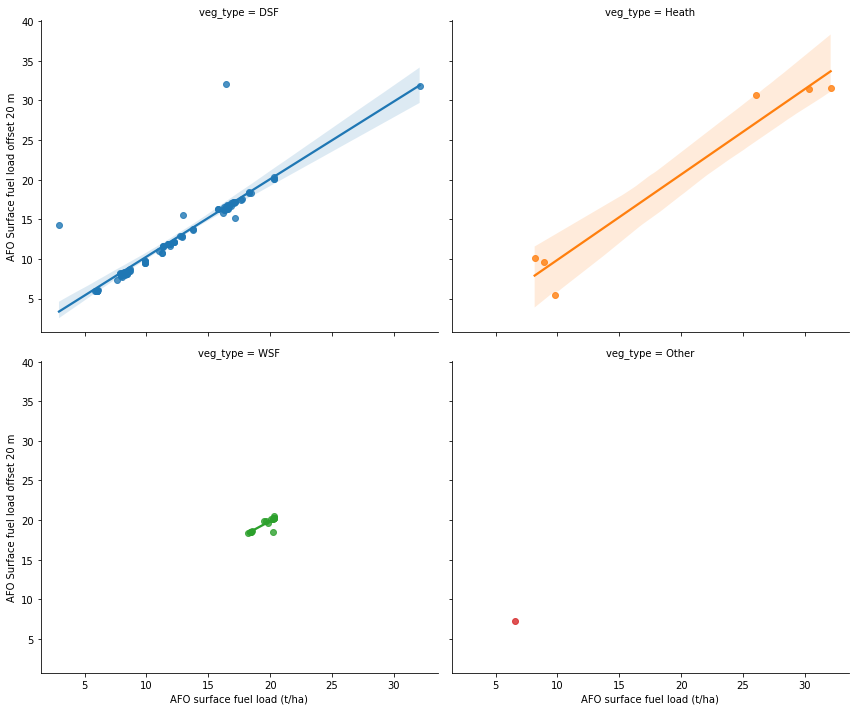

In [38]:
x = 'afo_surface'
y = 'afo_surface_off'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

If the data are so sensitive lets resample it - at a grid cell size of 50 m

In [77]:
res = 30
lr_cc_paths = rasters_resample(cc_paths, res)

In [78]:
gdf['afo_cc_lr'] = read_afo(lr_cc_paths, gdf)
labels['afo_cc_lr'] = f'AFO Canopy Cover (%) {res} m resolution'
gdf.head()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,zone,loc_cartesian,...,afo_litter,afo_surface,afo_elevated,afo_bark,afo_cc_off,afo_ch_off,afo_surface_off,afo_ch_lr,afo_cc_lr,afo_surface_lr
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,56,POINT (340759.370 6282663.946),...,17.716690,17.716690,1.855503,3.123432,47.983017,4.949597,17.553732,5.532097,51.327278,4.891547
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,56,POINT (340731.620 6282637.380),...,17.689646,17.689646,1.800139,3.030236,55.959557,6.806909,17.474041,4.064364,47.006329,5.250886
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,56,POINT (340714.968 6282610.405),...,17.148125,17.148125,1.230490,2.071327,20.561842,1.744455,15.179890,3.470045,42.904411,4.947034
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,56,POINT (319470.917 6217334.192),...,14.651359,16.660486,6.413480,3.069542,81.923386,10.693882,16.767370,10.508323,86.425781,10.500488
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,56,POINT (319479.542 6217386.212),...,14.508380,16.497902,5.340499,2.556005,83.468933,7.897730,16.324308,7.762209,67.783195,5.126096


AFO Canopy Cover (%) 30 m resolution v Mean canopy cover (%)
stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.00


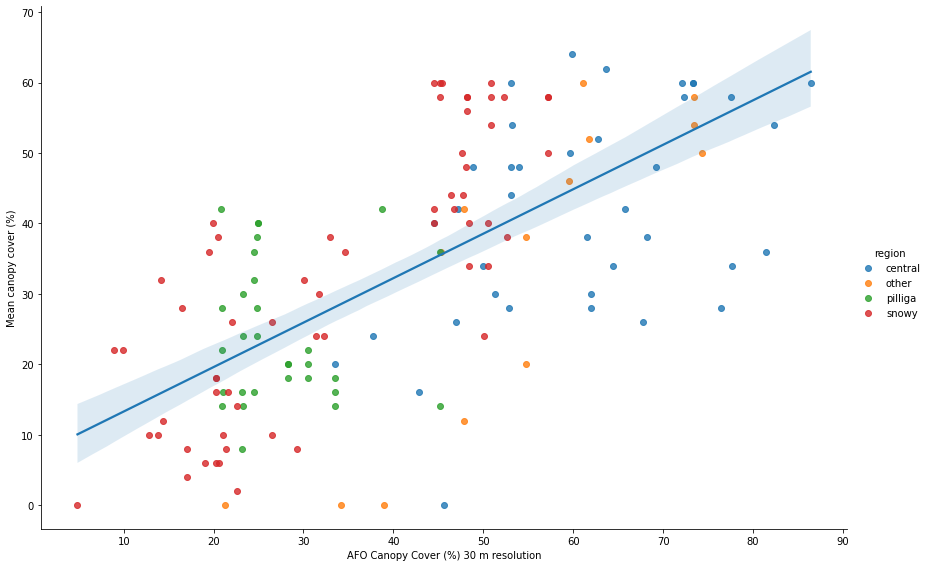

central stats:
pearson r: 0.48 	 r sq: 0.23 	 p: 0.00
other stats:
pearson r: 0.86 	 r sq: 0.74 	 p: 0.00
pilliga stats:
pearson r: -0.01 	 r sq: 0.00 	 p: 0.97
snowy stats:
pearson r: 0.81 	 r sq: 0.66 	 p: 0.00


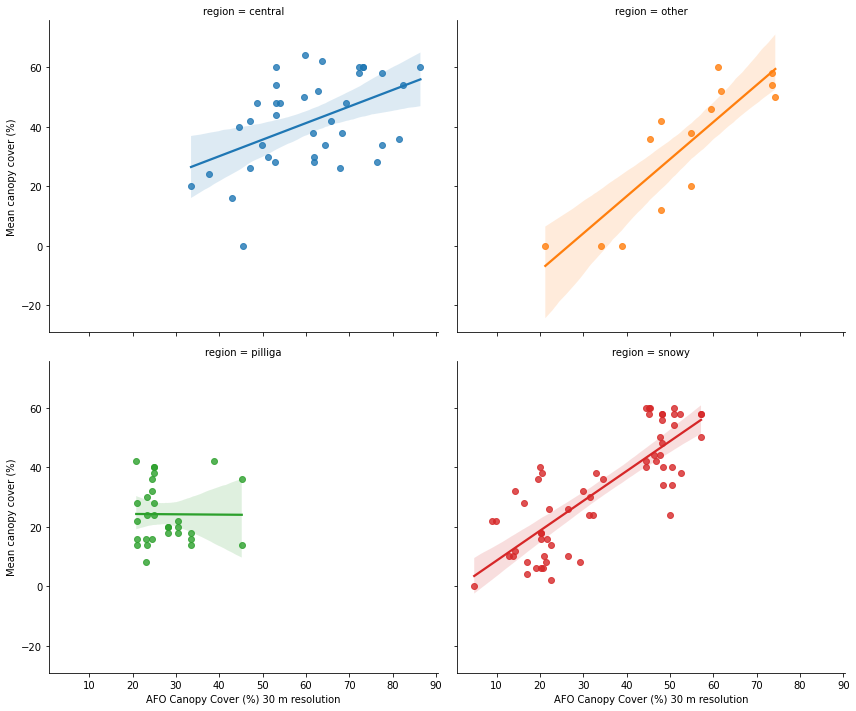

DSF stats:
pearson r: 0.67 	 r sq: 0.44 	 p: 0.00
Heath stats:
pearson r: 0.65 	 r sq: 0.42 	 p: 0.17
WSF stats:
pearson r: 0.23 	 r sq: 0.05 	 p: 0.36


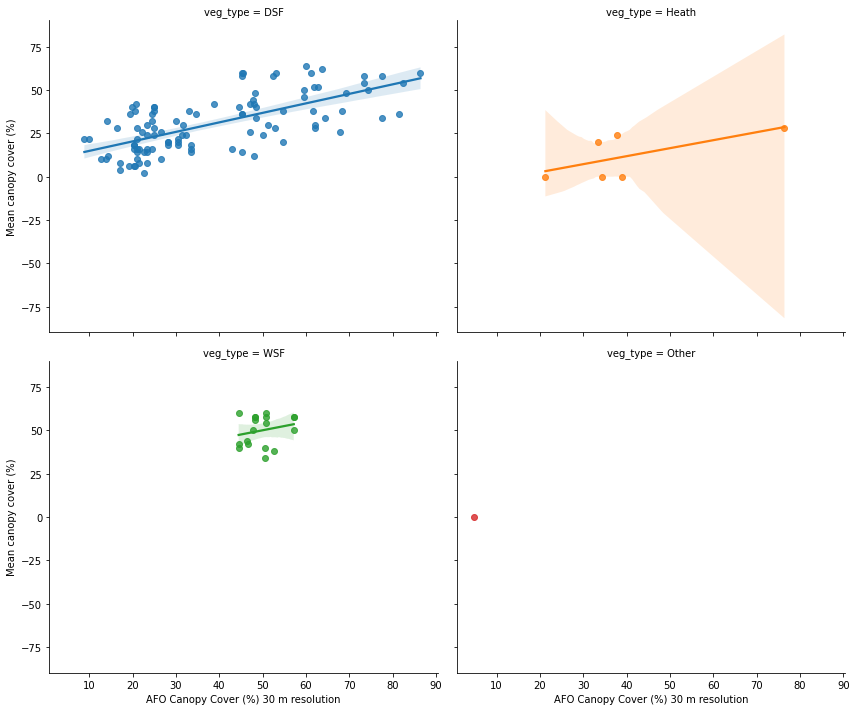

In [79]:
x = 'afo_cc_lr'
y = 'canopy_cov_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
Input CRS is: EPSG:32756
AFO Surface Cover 30 m resolution v Mean litter depth (mm)
stats:
pearson r: 0.58 	 r sq: 0.34 	 p: 0.00


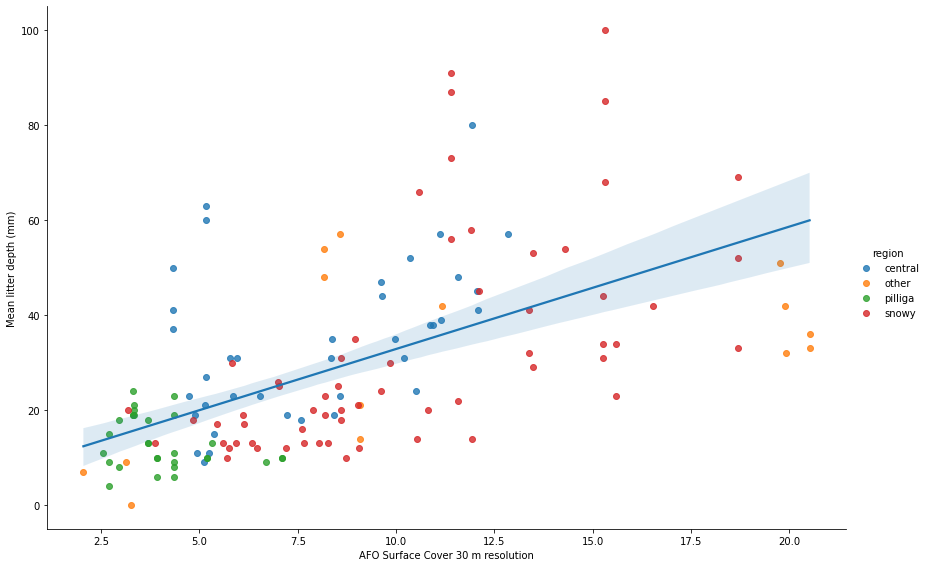

central stats:
pearson r: 0.46 	 r sq: 0.21 	 p: 0.00
other stats:
pearson r: 0.49 	 r sq: 0.24 	 p: 0.07
pilliga stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.17
snowy stats:
pearson r: 0.61 	 r sq: 0.37 	 p: 0.00


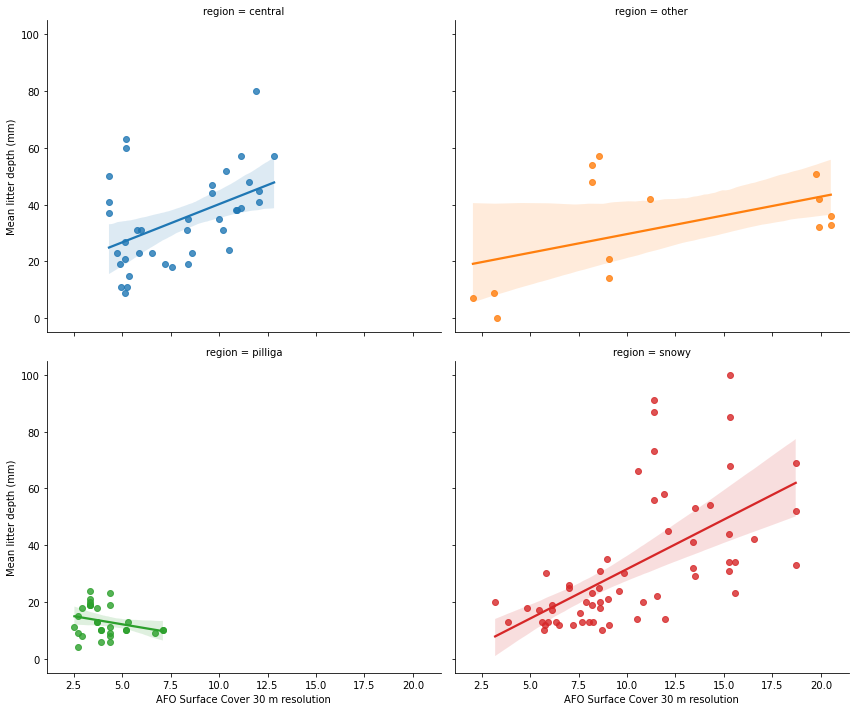

DSF stats:
pearson r: 0.61 	 r sq: 0.37 	 p: 0.00
Heath stats:
pearson r: 0.78 	 r sq: 0.61 	 p: 0.07
WSF stats:
pearson r: -0.40 	 r sq: 0.16 	 p: 0.10


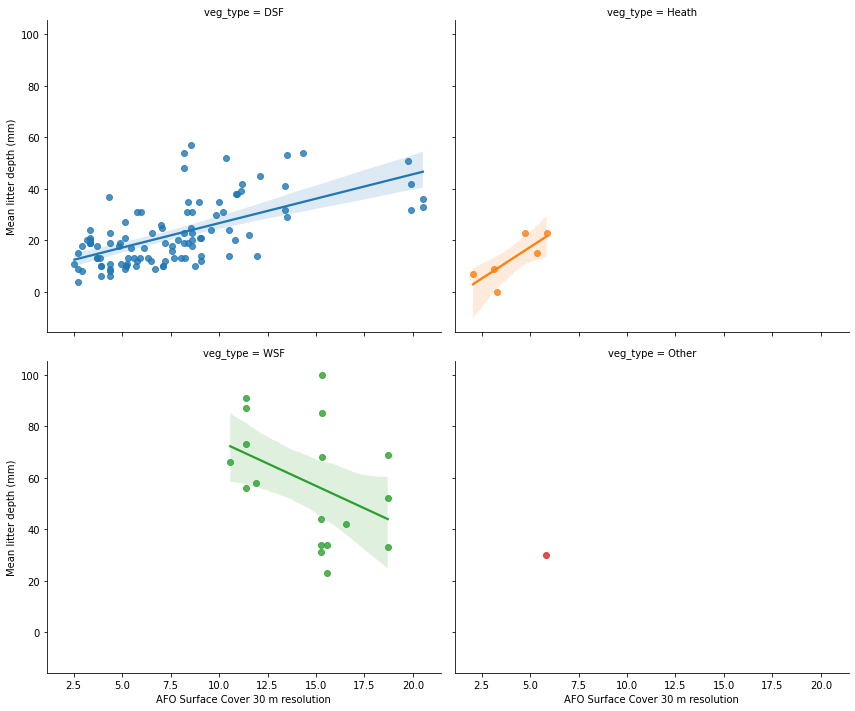

In [76]:
res = 30
label = 'afo_surface_lr'
paths = rasters_resample(ch_paths, res)
gdf[label] = read_afo(paths, gdf)
labels[label] = f'AFO Surface Cover {res} m resolution'
x = label
y = 'litter_d_m'
df = gdf
reg_plot(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='region')
plt.show()
reg_plots(x, y, df, hue='veg_type')
plt.show()

## RFS Corporate Data

In [85]:
def read_rfs(path: str, coord_df: GeoDataFrame) -> Series:

    coord_df = coord_df[['geometry']]
    with rasterio.open(path, 'r') as src:
        print(f'Input CRS is: {src.crs}')
        coord_df = coord_df.to_crs(src.crs)
        site_coords = [
            (x,y) for x,y in zip(coord_df['geometry'].x, coord_df['geometry'].y)
        ]
        coord_df['sample_data'] = [x[0] for x in src.sample(site_coords)]
    return coord_df['sample_data']

In [93]:
path = 'spatial_data/RFS/Bark_FuelTypeV211_202109201.tif'
gdf['rfs_bark'] = read_rfs(path,gdf)
labels['rfs_bark'] = 'RFS Bark Fuel Load 02109201'
path = 'spatial_data/RFS/Canopy_FuelTypeV2111.tif'
gdf['rfs_canopy'] = read_rfs(path,gdf)
labels['rfs_canopy'] = 'RFS Canopy Fuel Load 02109201'
path = 'spatial_data/RFS/Elevated_FuelTypeV211_202109201.tif'
gdf['rfs_elevated'] = read_rfs(path,gdf)
labels['rfs_elevated'] = 'RFS Elevated Fuel Load 02109201'
path = 'spatial_data/RFS/Surface_FuelTypeV211_202109201.tif'
gdf['rfs_surface'] = read_rfs(path,gdf)
labels['rfs_surface'] = 'RFS Surface Fuel Load 02109201'
gdf.head()

Input CRS is: EPSG:3308
Input CRS is: EPSG:3308
Input CRS is: EPSG:3308
Input CRS is: EPSG:3308


,id,site,plot,region,geometry,veg_type,fire_hist,loc_accuracy,zone,loc_cartesian,...,afo_ch_off,afo_surface_off,afo_ch_lr,afo_cc_lr,afo_surface_lr,rfs_surfac,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
0,ccfa3f44-ca62-46fd-bc88-e41f28247cd3,EC10,1,central,POINT (151.28407 -33.58385),DSF,2,4.658635,56,POINT (340759.370 6282663.946),...,4.949597,17.553732,5.532097,51.327278,4.891547,6.020303,1.355535,9.6,0.364655,6.020303
1,4d19111d-9db7-4087-9fff-627dbf92f9f4,EC10,2,central,POINT (151.28377 -33.58408),DSF,2,4.646899,56,POINT (340731.620 6282637.380),...,6.806909,17.474041,4.064364,47.006329,5.250886,6.020303,1.355535,9.6,0.364655,6.020303
2,9f8027da-efe2-4dbd-a281-9685e01b3fc6,EC10,3,central,POINT (151.28358 -33.58432),DSF,2,4.675196,56,POINT (340714.968 6282610.405),...,1.744455,15.179890,3.470045,42.904411,4.947034,6.020303,1.355535,9.6,0.364655,6.020303
3,f4731772-5879-4fa8-b69f-9f0fe8e53adc,EC11,2,central,POINT (151.04137 -34.16933),DSF,None,4.668194,56,POINT (319470.917 6217334.192),...,10.693882,16.767370,10.508323,86.425781,10.500488,8.952730,1.414082,3.5,3.012818,8.952730
4,399e8689-019a-4776-a6b7-8186c7cdc404,EC11,3,central,POINT (151.04147 -34.16886),DSF,None,4.658071,56,POINT (319479.542 6217386.212),...,7.897730,16.324308,7.762209,67.783195,5.126096,8.952730,1.414082,3.5,3.012818,8.952730


In [96]:
df_corr = gdf.corr(method='pearson')
df_corr

,loc_accuracy,zone,dist,litter_d_m,litter_cov,litter_load,ns_h_m,ns_cov,ns_load,elev_h_m,...,afo_ch_off,afo_surface_off,afo_ch_lr,afo_cc_lr,afo_surface_lr,rfs_surfac,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
loc_accuracy,1.000000,-0.088256,-0.051512,0.112384,-0.003259,-0.043230,-0.067725,0.081307,-0.013285,0.103546,...,0.150394,0.139237,0.125681,0.003181,0.129053,0.119698,0.090835,0.078571,-0.004282,0.119698
zone,-0.088256,1.000000,0.252969,0.188937,-0.118092,0.133455,0.131538,-0.203866,0.272451,0.378608,...,0.111878,0.379838,0.080132,0.697372,0.076834,0.408760,0.507507,-0.432926,0.726058,0.408760
dist,-0.051512,0.252969,1.000000,0.008529,0.027394,0.019914,0.029299,0.102452,0.204400,0.230979,...,-0.104760,0.023882,-0.113783,0.118040,-0.114171,0.182581,0.052788,-0.120418,0.357331,0.182581
litter_d_m,0.112384,0.188937,0.008529,1.000000,0.317014,0.919460,0.224079,0.138200,0.188182,0.280819,...,0.560033,0.412779,0.616200,0.444516,0.581219,0.407038,0.619953,0.133364,0.121601,0.407038
litter_cov,-0.003259,-0.118092,0.027394,0.317014,1.000000,0.362295,0.001048,0.264071,0.014278,0.026849,...,0.236323,0.107368,0.282809,0.045176,0.263830,0.241863,0.146062,0.082477,0.013880,0.241863
litter_load,-0.043230,0.133455,0.019914,0.919460,0.362295,1.000000,0.239996,0.167273,0.188283,0.222281,...,0.445040,0.327906,0.525382,0.344686,0.492818,0.344984,0.511792,0.093358,0.113079,0.344984
ns_h_m,-0.067725,0.131538,0.029299,0.224079,0.001048,0.239996,1.000000,0.553662,0.455636,0.460361,...,-0.025958,0.129206,-0.083362,-0.081089,-0.096172,-0.083556,0.015352,-0.185090,0.129139,-0.083556
ns_cov,0.081307,-0.203866,0.102452,0.138200,0.264071,0.167273,0.553662,1.000000,0.214662,0.314499,...,0.094548,0.037606,0.069762,-0.154049,0.080595,-0.091579,-0.102012,0.237846,-0.143601,-0.091579
ns_load,-0.013285,0.272451,0.204400,0.188182,0.014278,0.188283,0.455636,0.214662,1.000000,0.559535,...,-0.147564,-0.011972,-0.228564,0.007939,-0.199327,0.163403,0.079989,-0.220701,0.352439,0.163403
elev_h_m,0.103546,0.378608,0.230979,0.280819,0.026849,0.222281,0.460361,0.314499,0.559535,1.000000,...,0.149182,0.181804,0.089517,0.178519,0.099582,0.104055,0.282233,0.019912,0.271427,0.104055


In [111]:
df_corr[['afo_cc', 'afo_lfd', 'afo_ch', 'afo_cbh', 'afo_litter', 'afo_surface', 'afo_elevated', 'afo_bark']].iloc[np.r_[3:15, 32:32]]

,afo_cc,afo_lfd,afo_ch,afo_cbh,afo_litter,afo_surface,afo_elevated,afo_bark
litter_d_m,0.353170,-0.149710,0.495831,0.193215,0.490384,0.508517,0.404072,0.690024
litter_cov,0.020424,-0.102912,0.244053,0.164425,0.097956,0.120700,0.090090,0.121293
litter_load,0.258593,-0.101412,0.411155,0.165026,0.408429,0.426184,0.323718,0.568674
ns_h_m,-0.074975,0.103687,-0.129795,-0.187325,0.080328,0.082085,0.087025,0.052253
ns_cov,-0.184162,0.164300,0.034459,0.053096,0.081935,0.065870,-0.148173,-0.035989
ns_load,0.006199,0.118763,-0.184981,-0.201827,-0.023631,0.014287,0.180432,-0.001745
elev_h_m,0.160490,0.212856,0.098199,-0.047572,0.198271,0.223944,0.298951,0.312944
elev_cov,0.084107,0.255311,0.059883,-0.063541,0.113997,0.143060,0.178040,0.221774
elev_load,0.012920,0.182625,-0.046872,-0.117747,0.057657,0.075452,0.163522,0.069148
bark_load,-0.037023,-0.030943,0.325142,0.195205,0.096099,0.093692,-0.094156,0.167462


In [104]:
df_corr[['rfs_bark', 'rfs_canopy', 'rfs_elevated', 'rfs_surface']].iloc[3:23]

,rfs_bark,rfs_canopy,rfs_elevated,rfs_surface
litter_d_m,0.619953,0.133364,0.121601,0.407038
litter_cov,0.146062,0.082477,0.013880,0.241863
litter_load,0.511792,0.093358,0.113079,0.344984
ns_h_m,0.015352,-0.185090,0.129139,-0.083556
ns_cov,-0.102012,0.237846,-0.143601,-0.091579
ns_load,0.079989,-0.220701,0.352439,0.163403
elev_h_m,0.282233,0.019912,0.271427,0.104055
elev_cov,0.169052,0.170030,0.113547,-0.053214
elev_load,0.106926,-0.059344,0.268345,0.139048
bark_load,0.157634,0.368705,-0.176854,0.177658


AFO bark fuel load (t/ha) v RFS Bark Fuel Load 02109201
stats:
pearson r: 0.82 	 r sq: 0.67 	 p: 0.00


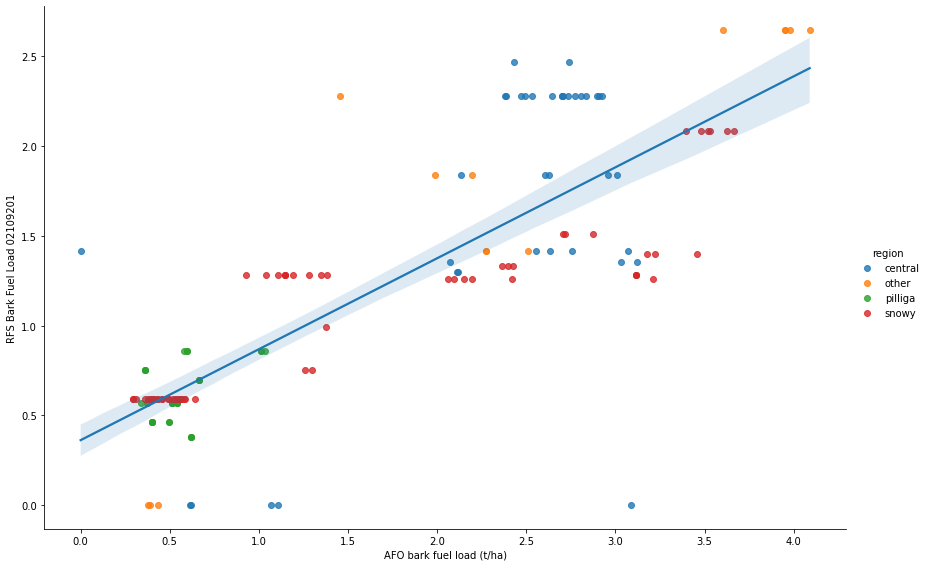

central stats:
pearson r: 0.59 	 r sq: 0.35 	 p: 0.00
other stats:
pearson r: 0.91 	 r sq: 0.83 	 p: 0.00
pilliga stats:
pearson r: 0.47 	 r sq: 0.22 	 p: 0.01
snowy stats:
pearson r: 0.89 	 r sq: 0.79 	 p: 0.00


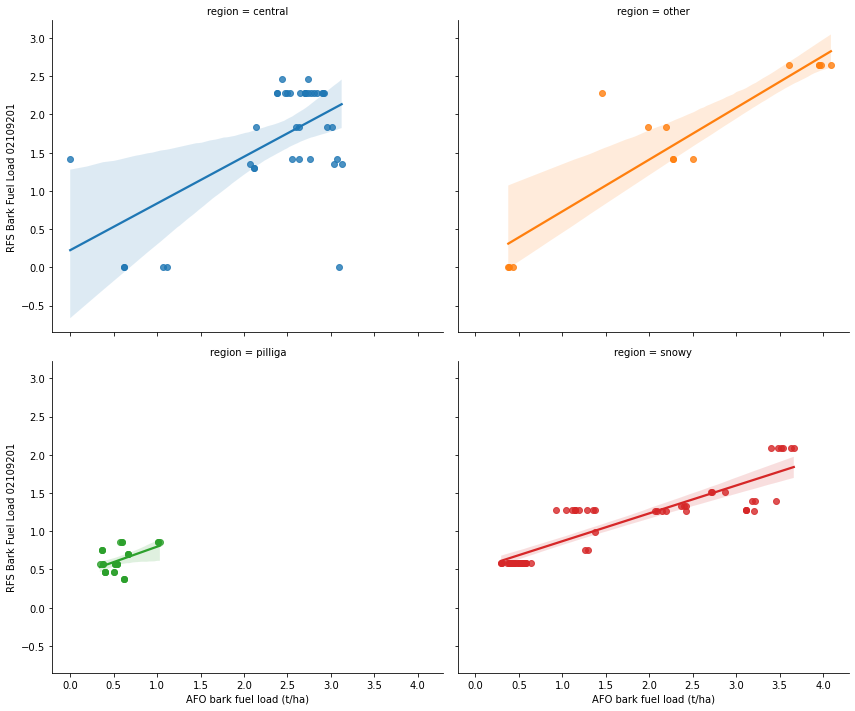

DSF stats:
pearson r: 0.85 	 r sq: 0.72 	 p: 0.00
Heath stats:
pearson r: 0.00 	 r sq: 0.00 	 p: 1.00
WSF stats:
pearson r: 0.56 	 r sq: 0.31 	 p: 0.02


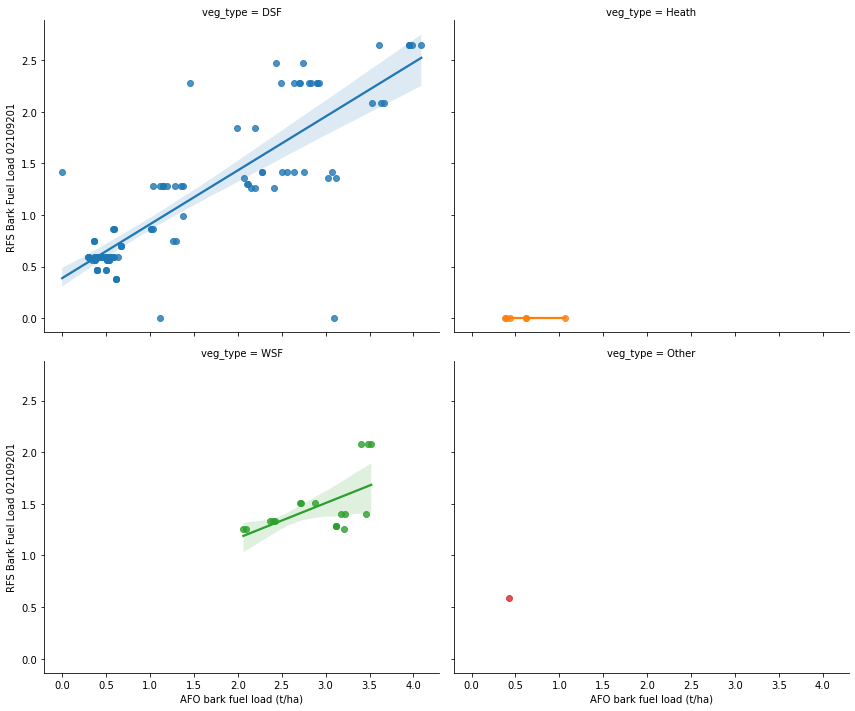

In [98]:
x = 'afo_bark'
y = 'rfs_bark'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()

AFO elevated fuel  load (t/ha) v RFS Elevated Fuel Load 02109201
stats:
pearson r: 0.78 	 r sq: 0.61 	 p: 0.00


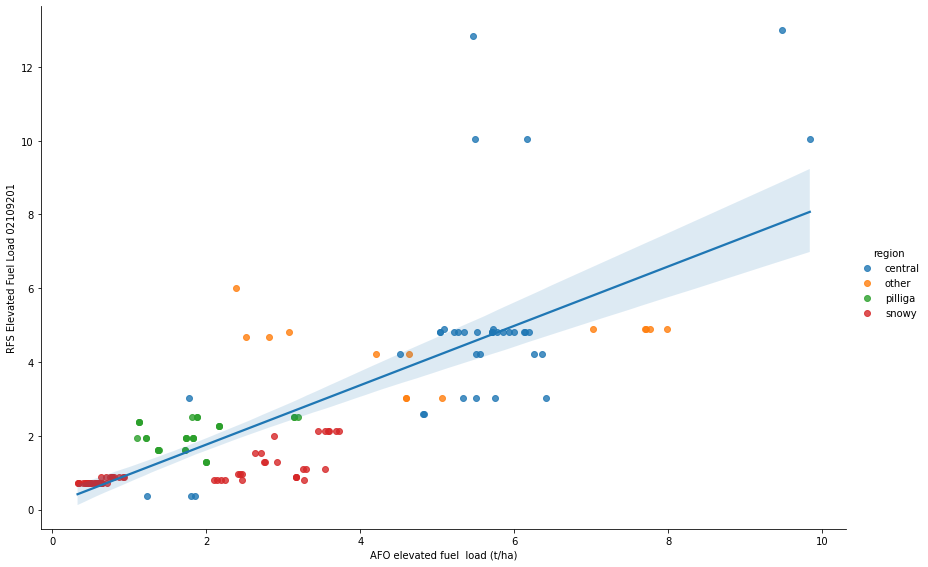

central stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.00
other stats:
pearson r: 0.06 	 r sq: 0.00 	 p: 0.83
pilliga stats:
pearson r: 0.32 	 r sq: 0.10 	 p: 0.09
snowy stats:
pearson r: 0.73 	 r sq: 0.53 	 p: 0.00


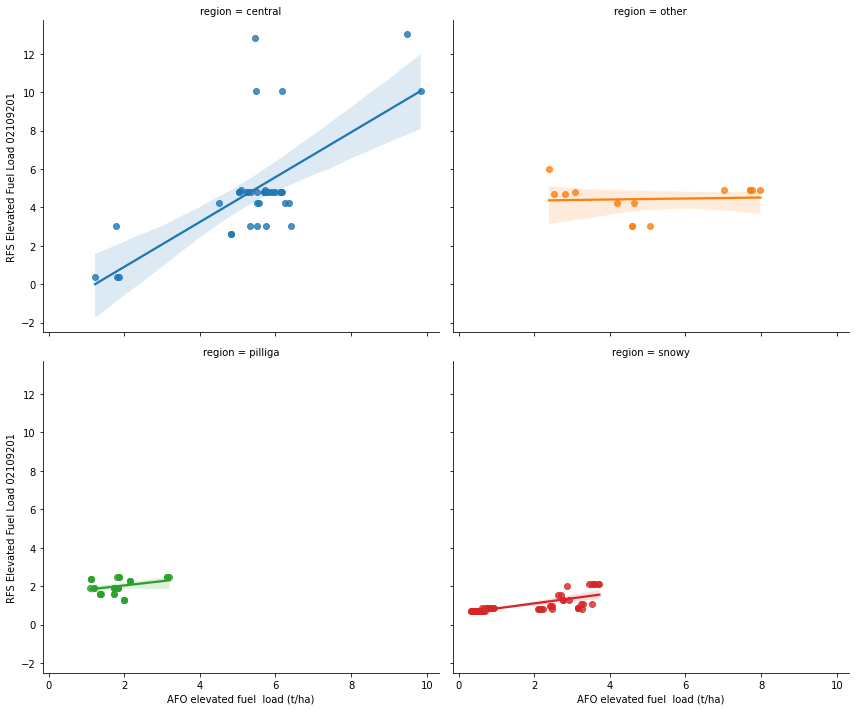

DSF stats:
pearson r: 0.87 	 r sq: 0.75 	 p: 0.00
Heath stats:
pearson r: 0.88 	 r sq: 0.77 	 p: 0.02
WSF stats:
pearson r: 0.56 	 r sq: 0.31 	 p: 0.02


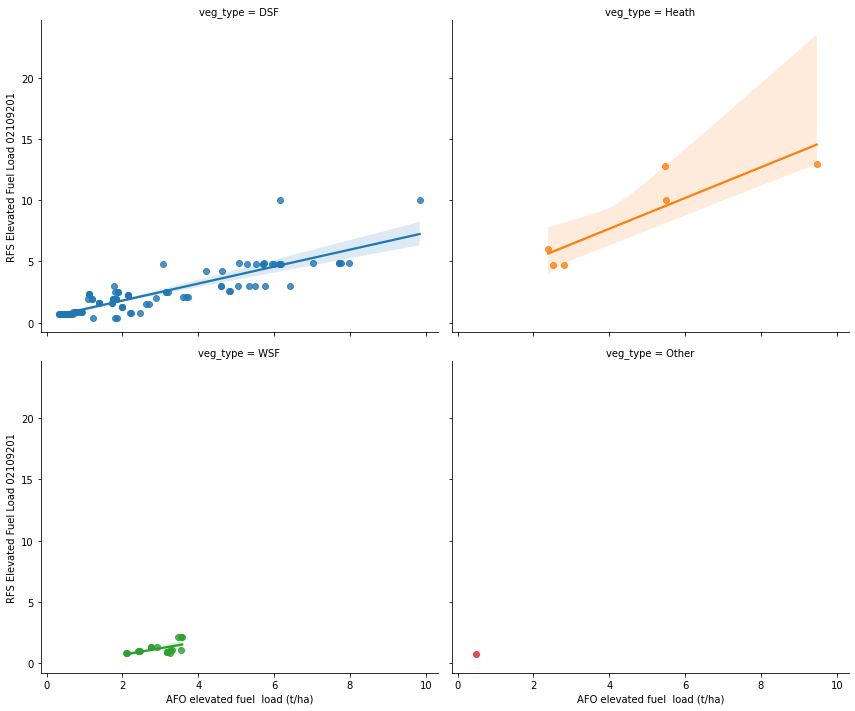

In [99]:
x = 'afo_elevated'
y = 'rfs_elevated'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()

AFO surface fuel load (t/ha) v RFS Surface Fuel Load
stats:
pearson r: 0.61 	 r sq: 0.38 	 p: 0.00


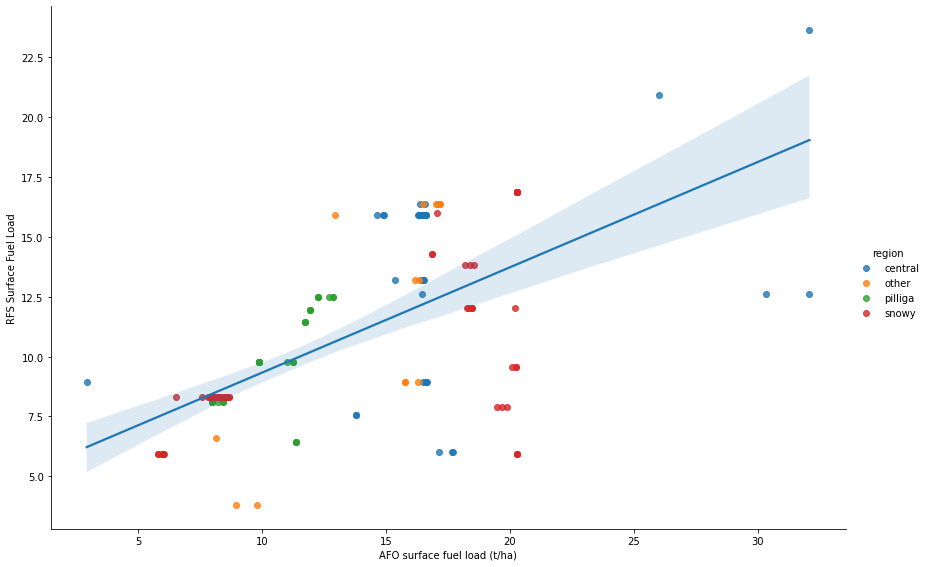

central stats:
pearson r: 0.34 	 r sq: 0.11 	 p: 0.04
other stats:
pearson r: 0.77 	 r sq: 0.59 	 p: 0.00
pilliga stats:
pearson r: 0.67 	 r sq: 0.45 	 p: 0.00
snowy stats:
pearson r: 0.66 	 r sq: 0.44 	 p: 0.00


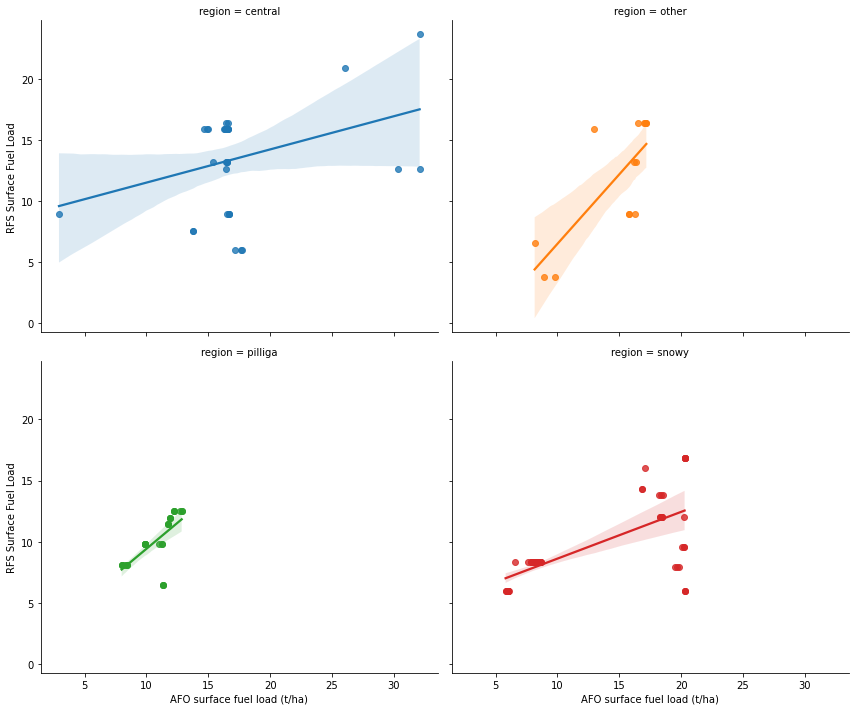

DSF stats:
pearson r: 0.68 	 r sq: 0.46 	 p: 0.00
Heath stats:
pearson r: 0.88 	 r sq: 0.78 	 p: 0.02
WSF stats:
pearson r: -0.26 	 r sq: 0.07 	 p: 0.30


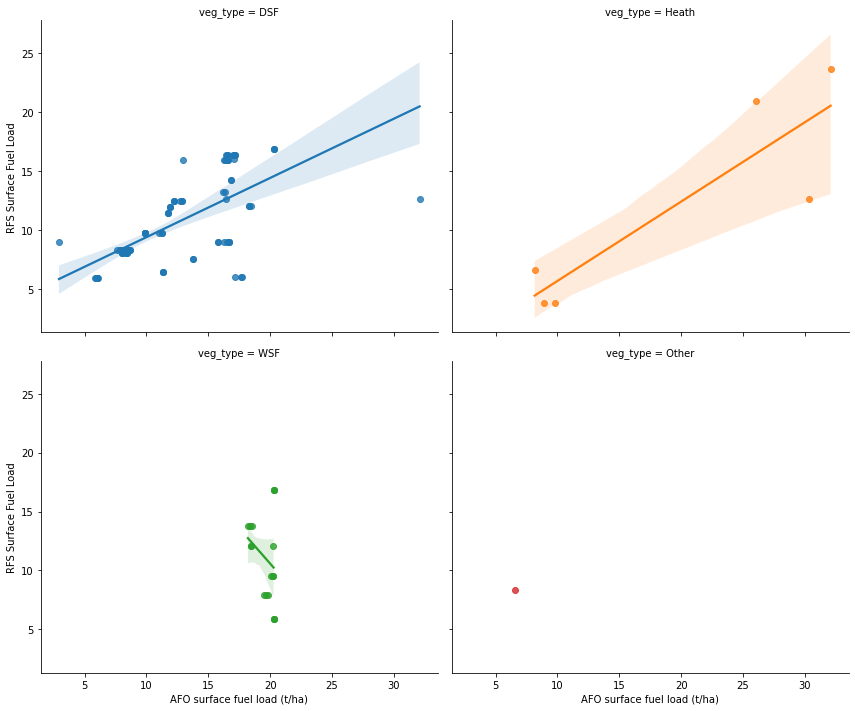

In [91]:
x = 'afo_surface'
y = 'rfs_surfac'
reg_plot(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='region')
plt.show()
reg_plots(x, y, gdf, hue='veg_type')
plt.show()